# ARMA, ARIMA, SARIMA


## Overview

- В предыдущих лекциях мы изучали стационарность, сглаживание, тренд, сезонность и автокорреляция, и мы рассмотрели 2 типа моделей:

> **MA models**: Текущее значение временного ряда линейно зависит от среднего значения предыдущих точек временного ряда.

> **AR models**: Текущее значение временного ряда линейно зависит от значений предыдущих точек временного ряда и случайной (шумовой) компоненты. 
  
- Теперь пришло время посмотреть, как работают ARMA, ARIMA, and SARIMA.

В частности, мы рассмотрим:

1. Модели авторегрессионной скользящей средней (ARMA).
2. Модели авторегрессионной интегрированной скользящей средней (ARIMA).
3. Модели SARIMA (модель ARIMA для данных с сезонностью).
4. Выбор лучшей модели.

In [2]:
# Imports
import warnings
warnings.filterwarnings("ignore")
from statsmodels.tools.sm_exceptions import ConvergenceWarning, ValueWarning
warnings.simplefilter('ignore', ConvergenceWarning)
warnings.simplefilter('ignore', ValueWarning)
warnings.simplefilter('ignore', UserWarning)
import time
from itertools import product
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import statsmodels as ss
import seaborn as sns
from tqdm.notebook import tqdm
from scipy import stats
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import month_plot, plot_acf, plot_pacf
from statsmodels.graphics.gofplots import qqplot
from statsmodels.tsa.stattools import adfuller, acf, pacf
from statsmodels.tsa.seasonal import STL, seasonal_decompose
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tools.eval_measures import mse
from statsmodels.tsa.statespace.tools import diff
import pmdarima as pm
np.random.seed(0)
from scipy.fft import fft

def fft_analysis(signal):

    # Linear detrending
    slope, intercept = np.polyfit(np.arange(len(signal)), signal, 1)
    trend = np.arange(len(signal)) * slope + intercept
    detrended = signal - trend

    fft_values = fft(detrended)
    frequencies = np.fft.fftfreq(len(fft_values))

    # Remove negative frequencies and sort
    positive_frequencies = frequencies[frequencies > 0]
    magnitudes = np.abs(fft_values)[frequencies > 0]

    # Identify dominant frequency
    dominant_frequency = positive_frequencies[np.argmax(magnitudes)]
    print(f"Dominant Frequency: {dominant_frequency:.3f}")

    # Convert frequency to period (e.g., days, weeks, months, etc.)
    dominant_period = 1 / dominant_frequency
    print(f"Dominant Period: {dominant_period:.2f} time units")

    return dominant_period, positive_frequencies, magnitudes

---

## ARMA

Модель ARMA (также известная как подход *Бокса-Дженкинса*) объединяет две модели:

- Авторегрессионная (AR) модель порядка $p$.
- Модель скользящей средней (MA) порядка $q$.

- Когда у нас есть автокорреляция между результатами и их предками, во временном ряду будет закономерность.
- Эту связь можно смоделировать с помощью модели ARMA.
- Она позволяет нам предсказывать будущее с уровнем достоверности, пропорциональным силе связи и близости к известным значениям (прогноз слабеет по мере удаления).

**ℹ️ Примечание**

- Модели ARMA предполагают, что временной ряд стационарен.
- Хорошее практическое правило — иметь не менее 100 наблюдений при подгонке модели ARMA.

### Загрузить данные

- Далее мы рассмотрим среднемесячные температуры в период с 1907 по 1972 год.

In [3]:
# load data and convert to datetime
monthly_temp = pd.read_csv('https://zenodo.org/records/10951538/files/arima_temp.csv?download=1',
                           skipfooter=2,
                           header=0,
                           index_col=0,
                           names=['month', 'temp'],
                           engine='python')
monthly_temp.index = pd.to_datetime(monthly_temp.index)

- Вот как выглядят данные.

In [4]:
monthly_temp.head()

,temp
month,
1907-01-01,33.3
1907-02-01,46.0
1907-03-01,43.0
1907-04-01,55.0
1907-05-01,51.8


Немного статистики


In [6]:
monthly_temp.describe()

,temp
count,792.000000
mean,53.553662
std,15.815452
min,11.200000
25%,39.675000
50%,52.150000
75%,67.200000
max,82.400000


Строим график

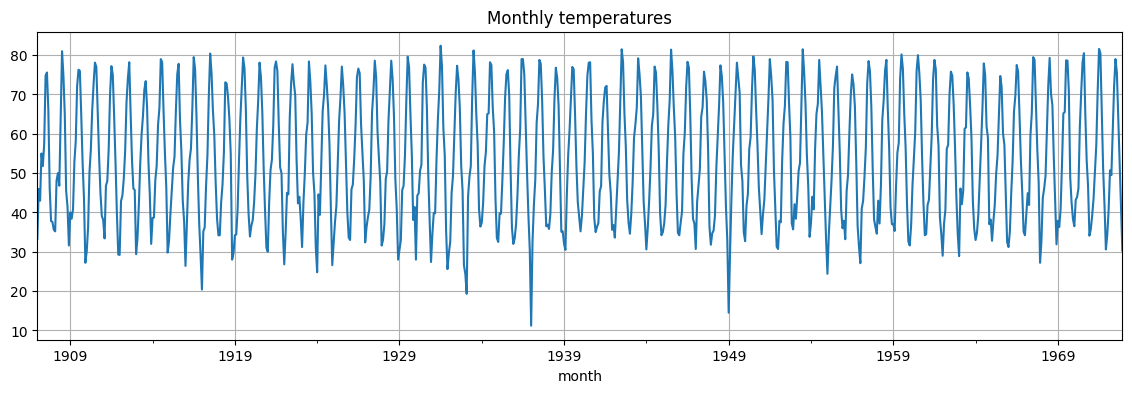

In [8]:
monthly_temp['temp'].plot(grid=True, figsize=(14, 4), title="Monthly temperatures");

- Рассчитайте среднегодовое значение и нанесите его на фактические данные.

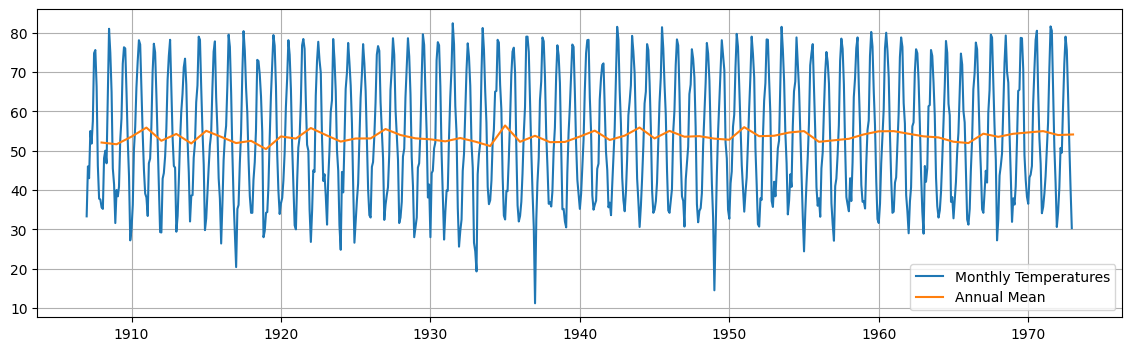

In [26]:
# Compute annual mean
annual_temp = monthly_temp.resample('YE').mean()
annual_temp.index.name = 'year'

plt.figure(figsize=(14, 4))
plt.plot(monthly_temp, label="Monthly Temperatures")
plt.plot(annual_temp, label="Annual Mean")
plt.grid(); plt.legend();

- Это дает нам указание на то, что среднее значение довольно постоянно на протяжении многих лет.
- Мы можем извлечь дополнительную информацию о базовой тенденции и сезонности, выполнив сезонную декомпозицию.
- Мы можем использовать как метод `seasonal_decompose`, так и метод `STL`.

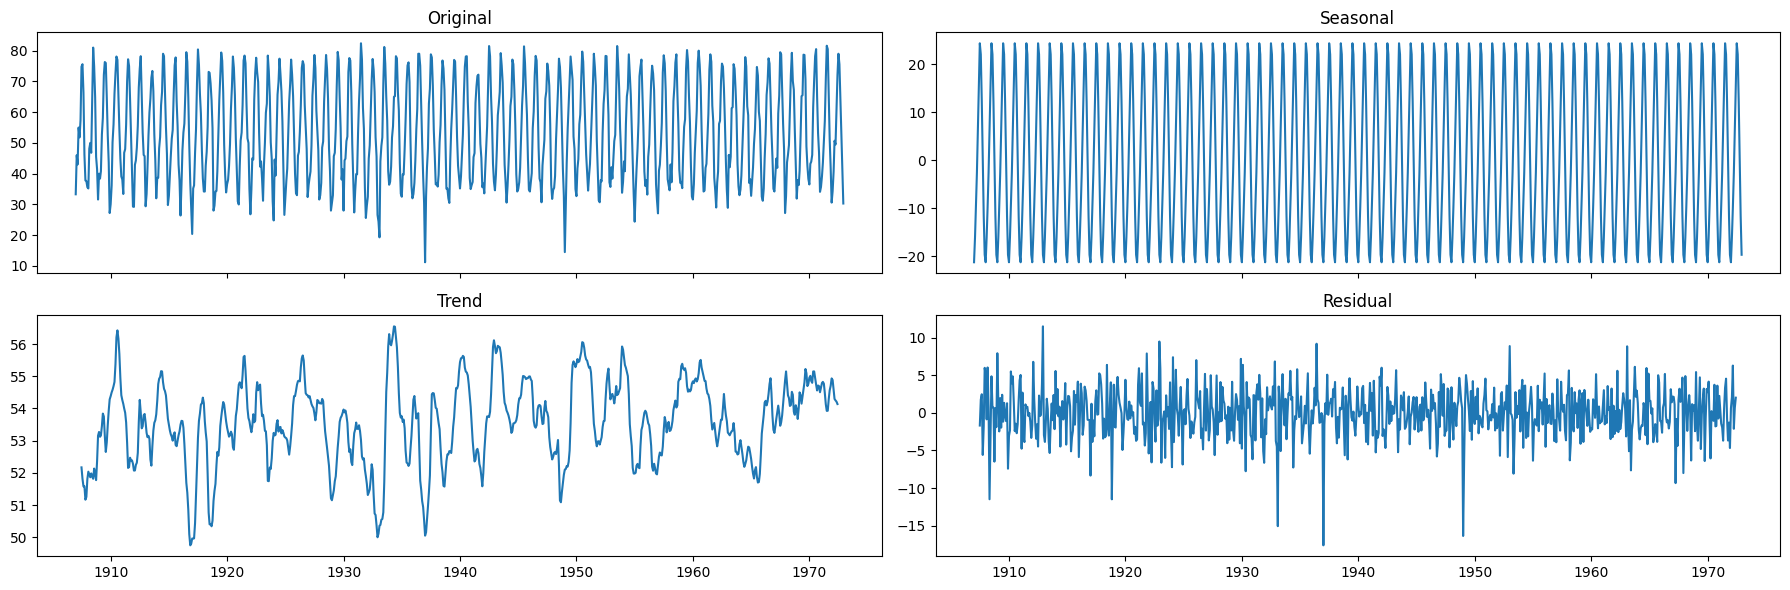

In [27]:
decomposition = seasonal_decompose(x=monthly_temp['temp'], model='additive', period=12)
seasonal, trend, resid = decomposition.seasonal, decomposition.trend, decomposition.resid

fig, axs = plt.subplots(2,2, sharex=True, figsize=(18,6))
axs[0,0].plot(monthly_temp['temp'])
axs[0,0].set_title('Original')
axs[0,1].plot(seasonal)
axs[0,1].set_title('Seasonal')
axs[1,0].plot(trend)
axs[1,0].set_title('Trend')
axs[1,1].plot(resid)
axs[1,1].set_title('Residual')
plt.tight_layout()

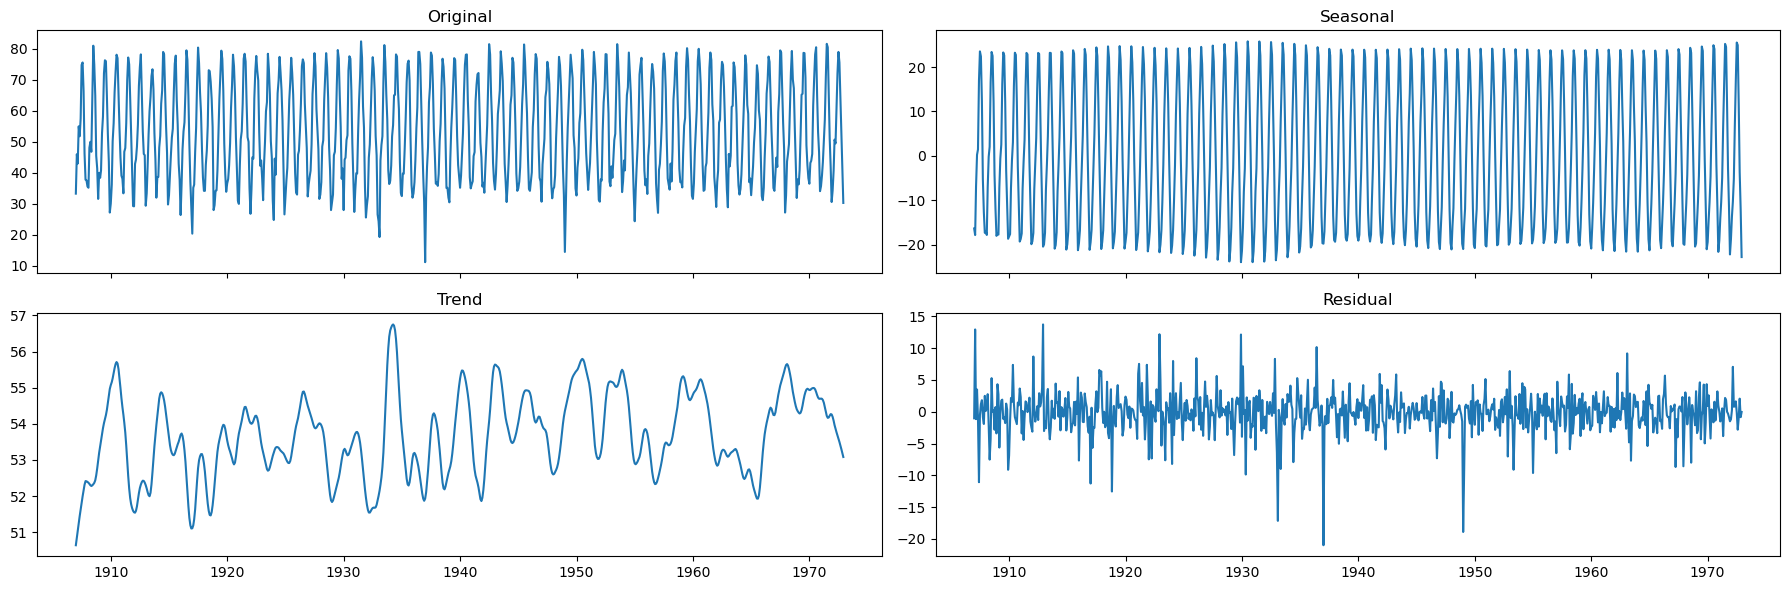

In [ ]:
decomposition = STL(endog=monthly_temp['temp'], period=12, seasonal=13, robust=True).fit()
seasonal, trend, resid = decomposition.seasonal, decomposition.trend, decomposition.resid

fig, axs = plt.subplots(2,2, sharex=True, figsize=(18,6))
axs[0,0].plot(monthly_temp['temp'])
axs[0,0].set_title('Original')
axs[0,1].plot(seasonal)
axs[0,1].set_title('Seasonal')
axs[1,0].plot(trend)
axs[1,0].set_title('Trend')
axs[1,1].plot(resid)
axs[1,1].set_title('Residual')
plt.tight_layout()

- Сезонность четко определена.
- В данных, похоже, нет сильной, изменяющегося во времени тренда.
- Мы можем предположить, что тренд постоянен.

## Этапы моделирования ARMA

Построение модели ARMA состоит из трех этапов:

1. Идентификация модели.
2. Оценка модели.
3. Оценка модели.

### Идентификация модели

- Идентификация модели заключается в нахождении порядков $p$ и $q$ компонентов AR и MA.
- Перед выполнением идентификации модели нам необходимо:
1. Определить, является ли временной ряд стационарным.
2. Определить, имеет ли временной ряд сезонную составляющую.

#### Определить стационарность

- Мы будем использовать уже известные нам инструменты (тест ADF).
- Мы также можем посмотреть на скользящее среднее и стандартное отклонение.

<br>
<div style="text-align: center; font-size: 30px; font-weight: bold;">⚠ Внимание! ⚠</div>
<br>

- Прежде чем продолжить, давайте рассмотрим следующий результат:

In [28]:
sinusoid = np.sin(np.arange(200))
_, pvalue, _, _, _, _ = adfuller(sinusoid)
print(f'p-value: {pvalue}')

p-value: 0.0


- Периодические сигналы по своей природе имеют средние значения и дисперсии, которые повторяются в течение периода цикла.
- Это означает, что их статистические свойства являются функциями времени в пределах каждого периода.
- Например, среднее значение периодического сигнала в течение одного цикла может быть постоянным.
- Однако при рассмотрении любой точки времени относительно цикла мгновенное среднее значение сигнала может меняться.
- Аналогично, дисперсия может колебаться в пределах цикла.
</br>


- Тест ADF специально ищет *единичный корень* (подробнее об этом позже).
- Единичный корень указывает на то, что шоки во временном ряду оказывают постоянное воздействие, вызывая дрейфы уровня ряда.
- Синусоидальная функция, напротив, по своей сути *возвращается к среднему* в пределах своих циклов.
- После пика синусоида возвращается к своему среднему значению, и любой "шок" в терминах сдвига фазы или изменения амплитуды не меняет ее колебательную природу.
</br>


- Важно отметить, что вывод теста ADF о стационарности синусоиды не означает, что синусоида стационарна.
- Вывод теста касается отсутствия единичного корня.
- Это не означает, что среднее значение и дисперсия постоянны в пределах периодических колебаний.

----

In [ ]:
def adftest(series, plots=True):
    out = adfuller(series, autolag='AIC')
    print(f'ADF Statistic: {out[0]:.2f}')
    print(f'p-value: {out[1]:.3f}')
    print(f"Critical Values: {[f'{k}: {r:.2f}' for r,k in zip(out[4].values(), out[4].keys())]}\n")

    if plots:
        # Compute rolling statistics
        rolmean = series.rolling(window=12).mean()
        rolstd = series.rolling(window=12).std()

        # Plot rolling statistics:
        plt.figure(figsize=(14, 4))
        plt.plot(series, color='tab:blue',label='Original')
        plt.plot(rolmean, color='tab:red', label='Rolling Mean')
        plt.plot(rolstd, color='black', label = 'Rolling Std')
        plt.legend(loc='best')
        plt.title('Rolling Mean and Standard Deviation')
        plt.grid();


ADF Statistic: -6.48
p-value: 0.000
Critical Values: ['1%: -3.44', '5%: -2.87', '10%: -2.57']



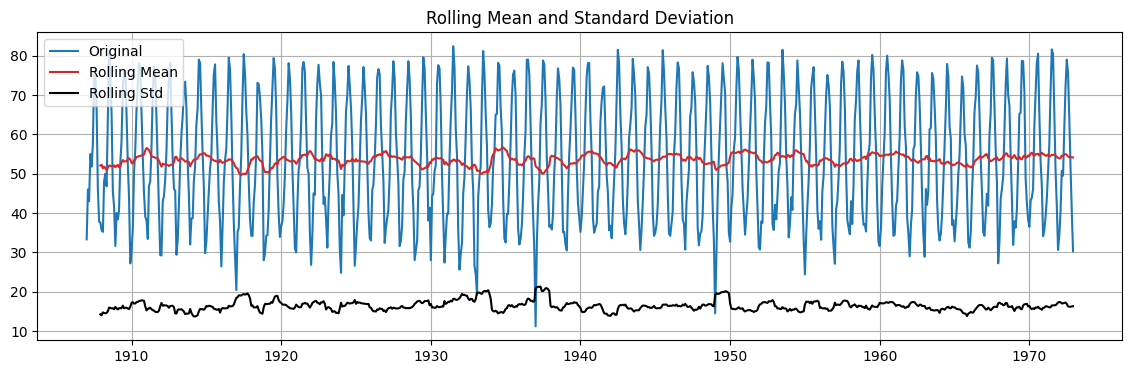

In [30]:
# run ADF on monthly temperatures
adftest(monthly_temp.temp)

- Значение p указывает на то, что временной ряд является стационарным...
- ... даже если он явно имеет периодическую компоненту.
- Скользящее среднее и скользящее стандартное отклонение кажутся глобально постоянными вдоль временного ряда...
- ... даже если они изменяются локально в пределах периода.

#### Определите сезонность

Мы можем определить наличие сезонности, используя следующие инструменты:
- График автокорреляции.
- График сезонных измений (график месяцев).
- Преобразование Фурье.

In [31]:
# run ADF on annual means
adftest(annual_temp.temp, plots=False) # no point in plotting the rolling mean/std here

ADF Statistic: -7.88
p-value: 0.000
Critical Values: ['1%: -3.54', '5%: -2.91', '10%: -2.59']



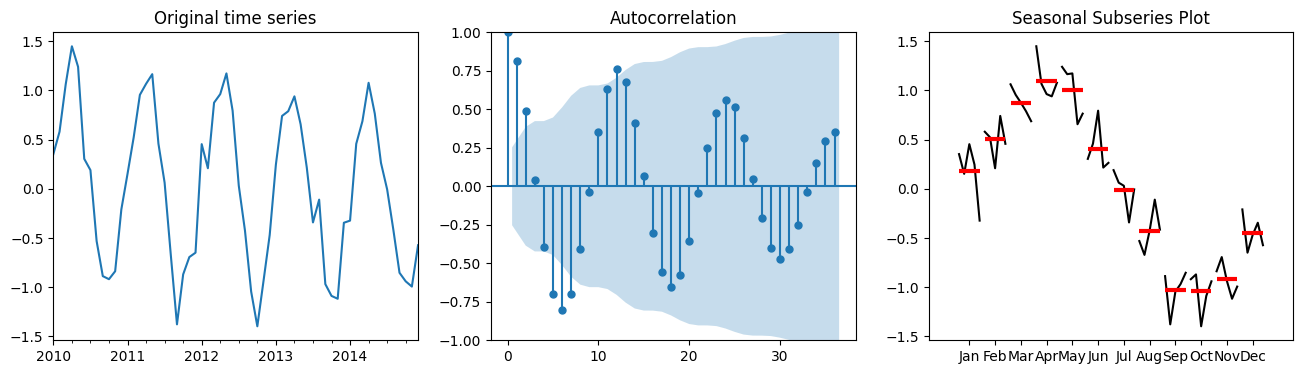

In [32]:
# Generate synthetic time series data
dates = pd.date_range(start='2010-01-01', periods=60, freq='M')  # Monthly data for 5 years
seas = 12 # change this and see how the plots change
data = np.sin(np.arange(60)*2*np.pi/seas) + np.random.normal(loc=0, scale=0.2, size=60)  # Seasonal data with noise
series = pd.Series(data, index=dates)
fig, axes = plt.subplots(1,3,figsize=(16,4))
series.plot(ax=axes[0], title="Original time series")

# ACF Plot
plot_acf(series, lags=36, ax=axes[1]);

# Convert series to a DataFrame and add a column for the month
df = series.to_frame(name='Value')
df['Month'] = df.index.month

# Seasonal Subseries Plot
month_plot(df['Value'], ax=axes[2]); axes[2].set_title("Seasonal Subseries Plot");

- Посмотрим на реальные данные

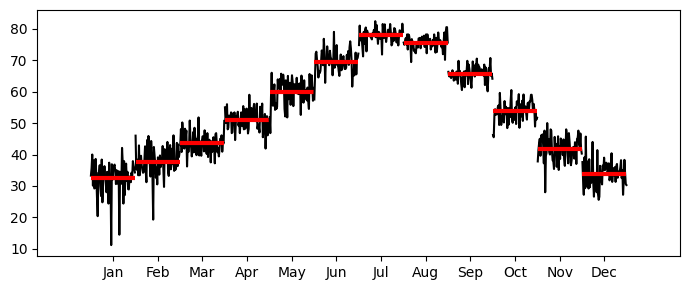

In [33]:
_, ax = plt.subplots(1,1, figsize=(7,3))
month_plot(monthly_temp, ax=ax)
plt.tight_layout();

- Отметим, что`violinplot` может сказать о временном ряде столько же, сколько и `month_plot`.

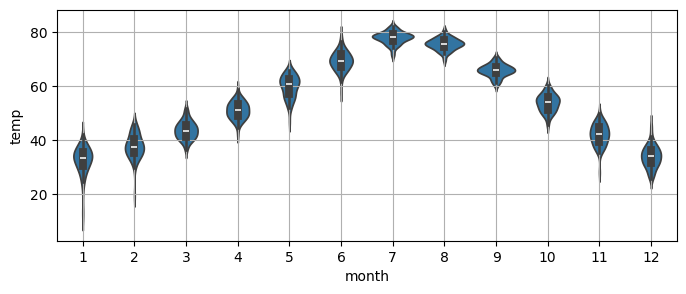

In [34]:
_, ax = plt.subplots(1,1, figsize=(8,3))
sns.violinplot(x=monthly_temp.index.month, y=monthly_temp.temp, ax=ax) # notice the indexing on the x by month
plt.grid();

- Наконец, чтобы получить численное значение основной периодичности, мы можем использовать преобразование Фурье (подробнее об этом позже).
- Здесь мы воспользуемся функцией, которую мы определили в первой лекции.

In [35]:
dominant_period, _, _ = fft_analysis(monthly_temp['temp'].values)
print(f"Dominant period: {np.round(dominant_period)}")

Dominant Frequency: 0.083
Dominant Period: 12.00 time units
Dominant period: 12.0


#### Удалить основную сезонность

- В этом случае ясно, что основная сезонность $L=12$.
- Мы можем удалить ее с помощью сезонной дифференциации.

In [36]:
monthly_temp['Seasonally_Differenced'] = monthly_temp['temp'].diff(12)

In [37]:
# Drop nan
monthly_temp_clean = monthly_temp.dropna()
monthly_temp_clean

,temp,Seasonally_Differenced
month,,
1908-01-01,35.6,2.3
1908-02-01,35.2,-10.8
1908-03-01,48.1,5.1
1908-04-01,50.0,-5.0
1908-05-01,46.8,-5.0
...,...,...
1972-08-01,75.6,-4.9
1972-09-01,64.1,-1.7
1972-10-01,51.7,0.6


**⚙ Попробуйте сами**

- Попробуйте переделать предыдущие графики на разностных данных!

#### Определение $p$ и $q$

Как мы узнали на предыдущем уроке, мы будем определять порядок AR $p$ и порядок MA $q$ с помощью:

- Графика функции автокорреляции (ACF).
- Графика частичной функции автокорреляции (PACF).

**AR($p$)**

- Порядок модели AR определяется следующим образом:
- Построить 95% доверительный интервал на PACF (выполняется автоматически statsmodels).
- Выбрать лаг $p$ таким образом, чтобы частичная автокорреляция стала незначительной для $p+1$ и далее.

- Если процесс зависит от предыдущих значений самого себя, то это процесс AR.
- Если он зависит от предыдущих ошибок, то это процесс MA.
- Процесс AR распространяет шоки бесконечно.
- Процессы AR будут демонстрировать экспоненциальный спад в ACF и отсечку в PACF.

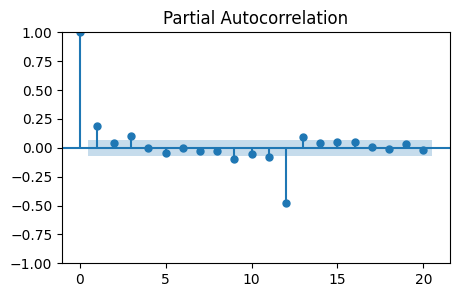

In [38]:
_, ax = plt.subplots(1, 1, figsize=(5, 3))
plot_pacf(monthly_temp_clean['Seasonally_Differenced'], lags=20, ax=ax);

- Похоже, что PACF становится равным нулю при лаге 2.
- Однако при лаге 3 наблюдается ненулевая частичная автокорреляция.
- Оптимальным значением может быть $p=1$, $p=2$ или $p=3$.
- Обратите внимание, что при более высоких лагах, особенно 12, наблюдаются высокие частные автокорреляции.
- Это эффект сезонности и сезонной дифференциации.
- Его не следует учитывать при выборе $p$.

**MA($q$)**

- Порядок модели MA определяется следующим образом:
- Построить 95% доверительный интервал на ACF (автоматически выполняется statsmodels).
- Выбрать лаг $q$ таким образом, чтобы ACF стал статистически нулевым для $q+1$ и далее.

- Модели MA не распространяют шоки бесконечно; они умирают после $q$ задержек.
- Процессы MA будут демонстрировать экспоненциальный спад в PACF и отсечку в ACF.

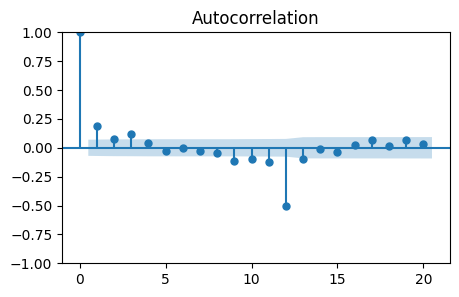

In [39]:
_, ax = plt.subplots(1, 1, figsize=(5, 3))
plot_acf(monthly_temp_clean['Seasonally_Differenced'], lags=20, ax=ax);

- Также в этом случае есть ненулевые автокорреляции на лагах 1 и 3.
- Итак, значения, которые следует попробовать, это $q=1$, $q=2$ или $q=3$.

### Оценка модели

- После определения порядков $p$ и $q$ необходимо оценить параметры $\phi_1, \dots, \phi_p$ части AR и параметры $\theta_1, \dots, \theta_q$ части MA.
- Оценка параметров модели ARMA — сложная нелинейная задача.
- Распространенными подходами являются нелинейные наименьшие квадраты и оценка максимального правдоподобия (MLE).
- Многие современные программы подойдут для модели ARMA.

- Мы разделили данные на две части:
- обучающий набор, который будет использоваться для подгонки параметров модели.
- тестовый набор, который будет использоваться позже для оценки эффективности прогнозирования модели на невидимых данных.

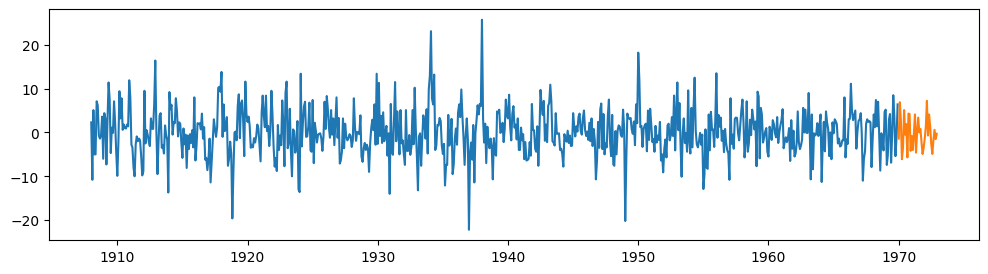

In [40]:
train = monthly_temp_clean['Seasonally_Differenced'][:-36]
test = monthly_temp_clean['Seasonally_Differenced'][-36:]

plt.figure(figsize=(12,3))
plt.plot(train)
plt.plot(test);

In [41]:
model = ARIMA(train, order=(3, 0, 3))  # ARIMA with d=0 is equivalent to ARMA
fit_model = model.fit()

print(fit_model.summary())

                                 SARIMAX Results                                  
Dep. Variable:     Seasonally_Differenced   No. Observations:                  744
Model:                     ARIMA(3, 0, 3)   Log Likelihood               -2248.069
Date:                    Thu, 12 Feb 2026   AIC                           4512.137
Time:                            18:24:57   BIC                           4549.034
Sample:                        01-01-1908   HQIC                          4526.360
                             - 12-01-1969                                         
Covariance Type:                      opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0641      0.244      0.263      0.793      -0.414       0.542
ar.L1         -0.0993      0.144     -0.692      0.489      -0.381       0.182
ar.L2         -0.830

### Проверка модели ARMA

- Как узнать, хороша ли ваша модель ARMA?
- Мы можем проверить остатки, т. е. то, что модель не смогла учесть.
- Остатки должны приближаться к гауссовскому распределению (т. е. белому шуму).
- В противном случае нам может потребоваться выбрать лучшую модель.

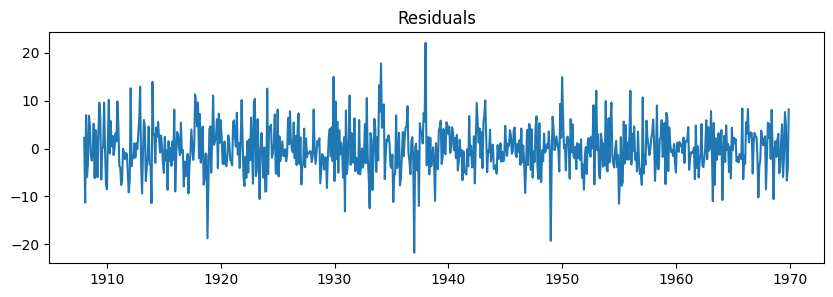

In [42]:
residuals = fit_model.resid

plt.figure(figsize=(10,3))
plt.plot(residuals)
plt.title("Residuals");

**🤔 Как проверить, выглядят ли остатки как шум?**

- Мы будем использовать как визуальный осмотр, так и статистические тесты.
- Визуальный осмотр:
- График ACF.
- Гистограмма.
- График QQ.
- Статистические тесты:
- Нормальность.
- Автокорреляция.
- Гетероскедастичность.

#### Визуальный осмотр

**График ACF**

- Проверяет наличие автокорреляции в остатках.
- Белый шум не должен показывать значительной автокорреляции при всех задержках.

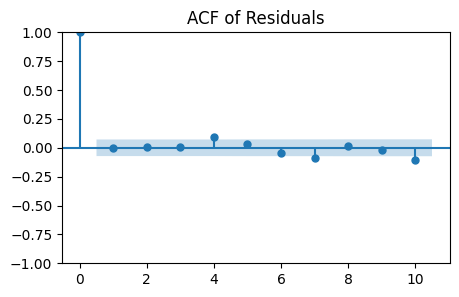

In [43]:
_, ax = plt.subplots(1, 1, figsize=(5, 3))
plot_acf(residuals, lags=10, ax=ax)
plt.title('ACF of Residuals')
plt.show()

**Гистограмма и QQ-график**
- Оцените нормальность остатков.
- Белый шум в идеале должен следовать нормальному распределению.

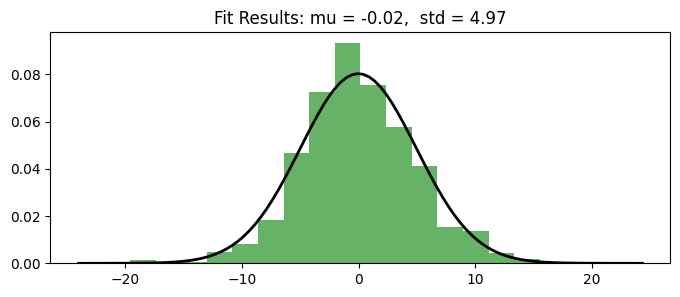

In [44]:
# Histogram
plt.figure(figsize=(8,3))
plt.hist(residuals, bins=20, density=True, alpha=0.6, color='g')
# Add the normal distribution curve
xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
p = stats.norm.pdf(x, np.mean(residuals), np.std(residuals))
plt.plot(x, p, 'k', linewidth=2)
title = "Fit Results: mu = %.2f,  std = %.2f" % (np.mean(residuals), np.std(residuals))
plt.title(title)
plt.show()

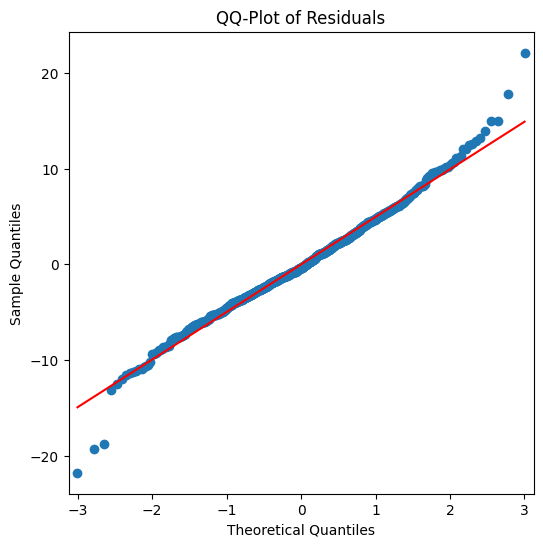

In [45]:
# QQ-Plot
_, ax = plt.subplots(1, 1, figsize=(6, 6))
qqplot(residuals, line='s', ax=ax)
plt.title('QQ-Plot of Residuals')
plt.show()

- Графики удобно суммируются в функции ``plot_diagnostics()``, которую можно вызвать для подходящей модели.

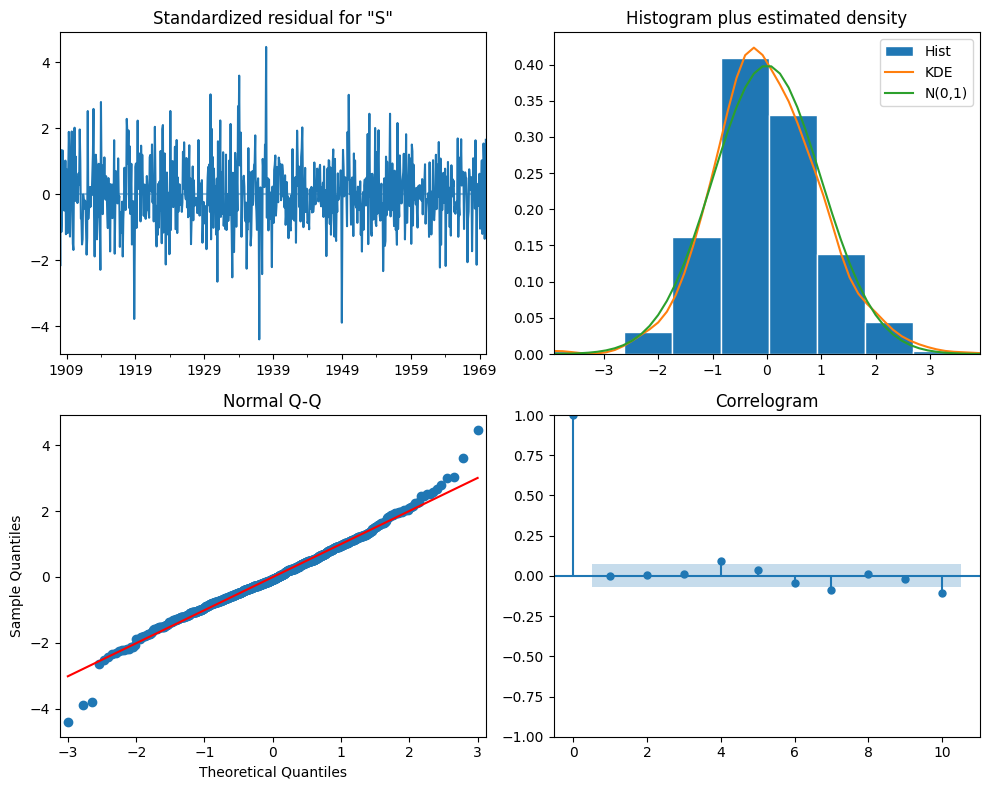

In [46]:
fit_model.plot_diagnostics(figsize=(10, 8))
plt.tight_layout();

#### Статистические тесты

**Нормальность: тесты Жака-Бера и Шапиро-Уилка**

> $H_0$: остатки распределены нормально.

In [47]:
norm_val, norm_p, skew, kurtosis = fit_model.test_normality('jarquebera')[0]
print('Normality (Jarque-Bera) p-value:{:.3f}'.format(norm_p))

Normality (Jarque-Bera) p-value:0.000


In [48]:
shapiro_test = stats.shapiro(residuals)
print(f'Normality (Shapiro-Wilk) p-value: {shapiro_test.pvalue:.3f}')

Normality (Shapiro-Wilk) p-value: 0.000


- Малые p-значения позволяют нам отвергнуть $H_0$.
- Вывод: остатки **не** распределены нормально.

**📝 Примечание**
- Для справки давайте посмотрим, что говорят эти тесты о данных, которые на самом деле распределены нормально.
- Попробуйте выполнить ячейку ниже несколько раз и посмотрите, насколько сильно меняются результаты каждый раз.
- Эти тесты становятся надежными только для больших размеров выборки ($N>5000$).

In [49]:
# generate random normal data
normal_data = np.random.normal(loc=0, scale=1, size=1000)

jb_test = stats.jarque_bera(normal_data)
print(f'Normality (Jarque-Bera) p-value: {jb_test.pvalue:.3f}')

shapiro_test = stats.shapiro(normal_data)
print(f'Normality (Shapiro-Wilk) p-value: {shapiro_test.pvalue:.3f}')

Normality (Jarque-Bera) p-value: 0.811
Normality (Shapiro-Wilk) p-value: 0.938


**Автокорреляция: тест Льюнга-Бокса**

> $H_0$: остатки распределены независимо (автокорреляция отсутствует).

- Для каждого лага существует $p$-значение.
- Здесь мы просто берем среднее значение, но можно также рассмотреть и самый большой лаг (`pval[-1]`).
- Также не всегда очевидно, сколько лагов следует использовать в тесте...

In [50]:
statistic, pval = fit_model.test_serial_correlation(method='ljungbox', lags=10)[0]
print(f'Ljung-Box p-value: {pval.mean():.3f}')

Ljung-Box p-value: 0.362


**Автокорреляция: тест Дарбина-Уотсона**

- Проверяет автокорреляцию в остатках.
- Нам нужно что-то между 1-3.
- 2 идеально (без последовательной корреляции).

In [51]:
durbin_watson = ss.stats.stattools.durbin_watson(fit_model.filter_results.standardized_forecasts_error[0, fit_model.loglikelihood_burn:])
print('Durbin-Watson: d={:.2f}'.format(durbin_watson))

Durbin-Watson: d=2.00


**Тест гетероскедастичности**

- Тесты на изменение дисперсии между остатками.
> $H_0$: гетероскедастичности нет.
- $H_0$ указывает на разные вещи в зависимости от альтернативы $H_A$:
    - $H_A$: увеличивается, $H_0$: дисперсия не увеличивается на протяжении ряда.
    - $H_A$: уменьшается, $H_0$: дисперсия не уменьшается на протяжении ряда.
    - $H_A$: двусторонний (по умолчанию), $H_0$: дисперсия не увеличивается и не уменьшается на протяжении ряда.

In [52]:
_, pval = fit_model.test_heteroskedasticity('breakvar', alternative='increasing')[0]
print(f'H_a: Increasing - pvalue:{pval:.3f}')

H_a: Increasing - pvalue:0.980


In [53]:
_, pval = fit_model.test_heteroskedasticity('breakvar', alternative='decreasing')[0]
print(f'H_a: Decreasing - pvalue:{pval:.3f}')

H_a: Decreasing - pvalue:0.020


In [54]:
_, pval = fit_model.test_heteroskedasticity('breakvar', alternative='two-sided')[0]
print(f'H_a: Two-sided - pvalue:{pval:.3f}')

H_a: Two-sided - pvalue:0.039


**Краткое изложение наших тестов**

Независимость:
- &#x2705; график ACF.
- &#x2705; тест Льюнга-Бокса.
- &#x2705; тест Дарбина-Уотсона.

Нормальность:
- &#x2705; график гистограммы/плотности.
- 🤔 график QQ
- &#x274C; Харк-Бера (надежен для выборки большого размера).
- &#x274C; Шапиро-Уилк (надежен для выборки большого размера).

Гетероскедастичность
- &#x274C; тест гетероскедастичности.

- Тесты немного неопределенные.
- Нет убедительных доказательств того, что модель очень хороша или очень плоха.
- Вероятно, разумно попробовать другие модели-кандидаты, например, `ARMA(2,0,2)`, и повторить тесты.

### Прогнозы модели ARMA

- После того, как модель будет подобрана, мы можем использовать ее для прогнозирования тестовых данных.
- Прогнозы имеют форму распределения.
- Другими словами, ARMA выполняет *вероятностное прогнозирование*.
- Среднее значение (мода) этого распределения соответствует наиболее вероятному значению и соответствует нашему прогнозу.
- Оставшуюся часть распределения можно использовать для вычисления доверительных интервалов.

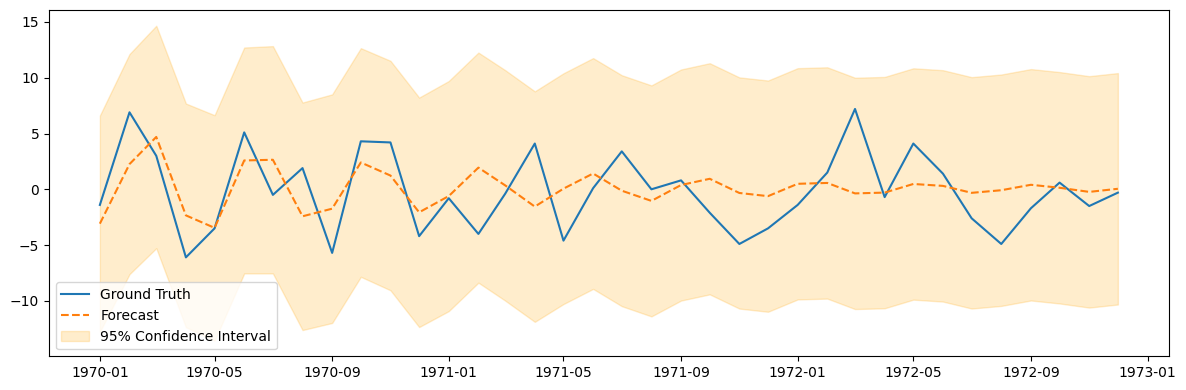

In [55]:
pred_summary = fit_model.get_prediction(test.index[0], test.index[-1]).summary_frame()

plt.figure(figsize=(12, 4))
plt.plot(test.index, test, label='Ground Truth')
plt.plot(test.index, pred_summary['mean'], label='Forecast', linestyle='--')
plt.fill_between(test.index, pred_summary['mean_ci_lower'], pred_summary['mean_ci_upper'],
                 color='orange', alpha=0.2, label='95% Confidence Interval')
plt.legend()
plt.tight_layout();

---

## ARIMA Model

- ARIMA означает Auto Regressive Integrated Moving Average (автоматическая регрессивная интегрированная скользящая средняя).
- Модели ARIMA состоят из трех компонентов:
- Модель AR.
- Интегрированный компонент (подробнее об этом чуть позже).
- Модель MA.

- Модель ARIMA обозначается как ARIMA($p, d, q$).
    - $p$ - порядок модели AR.
    - $d$ - количество раз, которое необходимо разбить на части.
    - $q$ - порядок модели MA.
    - $p$, $d$ и $q$ - неотрицательные целые числа.

- Как мы видели ранее, дифференциация нестационарных временных рядов данных один или несколько раз может сделать их стационарными.
- Это роль интегрированного (I) компонента ARIMA.
- $d$ - это количество раз, которое необходимо выполнить дифференциацию с задержкой 1 для данных.
    - $d=0$: без дифференциации.
    - $d=1$: однократная дифференциация.
    - $d=2$: двукратная дифференциация.

- Модель ARMA подходит для стационарных временных рядов, где среднее значение и дисперсия не меняются со временем.
- Модель ARIMA эффективно моделирует нестационарные временные ряды, дифференцируя данные.
- На практике ARIMA делает временной ряд стационарным перед применением модели ARMA.
- Давайте рассмотрим это на примере.

In [56]:
# Generate synthetic stationary data with an ARMA(1,1) process
n = 250
ar_coeff = np.array([1, -0.7]) # The first value refers to lag 0 and is always 1. In addition, AR coeff are negated.
ma_coeff = np.array([1, 0.7])  # The first value refers to lag 0 and is always 1
arma_data = ss.tsa.arima_process.ArmaProcess(ar_coeff, ma_coeff).generate_sample(nsample=n, burnin=1000)

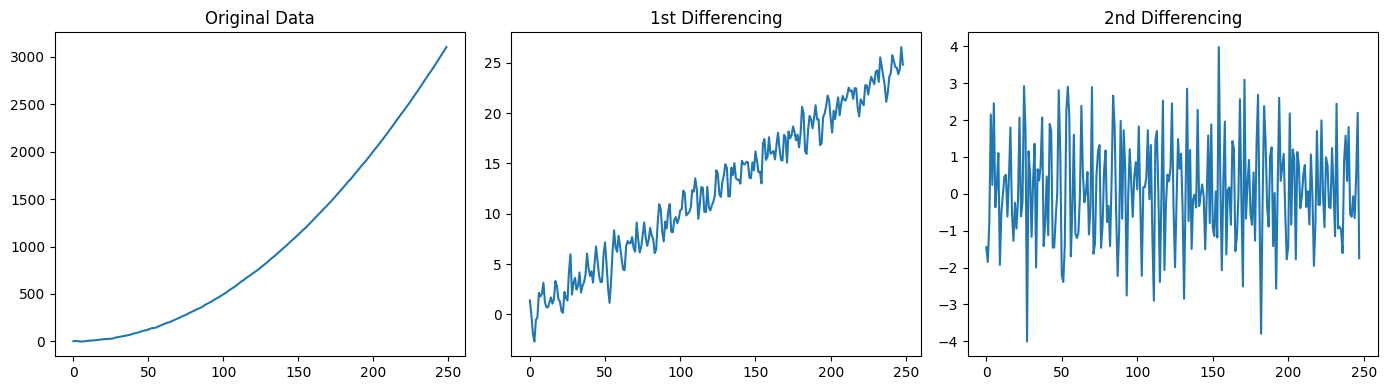

In [57]:
# Generate a synthetic non-stationary data (needs to be differenced twice to be stationary)
t = np.arange(n)
non_stationary_data = 0.05 * t**2 + arma_data  # Quadratic trend

fig, axes = plt.subplots(1, 3, figsize=(14, 4))
axes[0].plot(non_stationary_data)
axes[0].set_title('Original Data')
axes[1].plot(diff(non_stationary_data, k_diff=1))
axes[1].set_title('1st Differencing')
axes[2].plot(diff(non_stationary_data, k_diff=2))
axes[2].set_title('2nd Differencing')
plt.tight_layout();

220


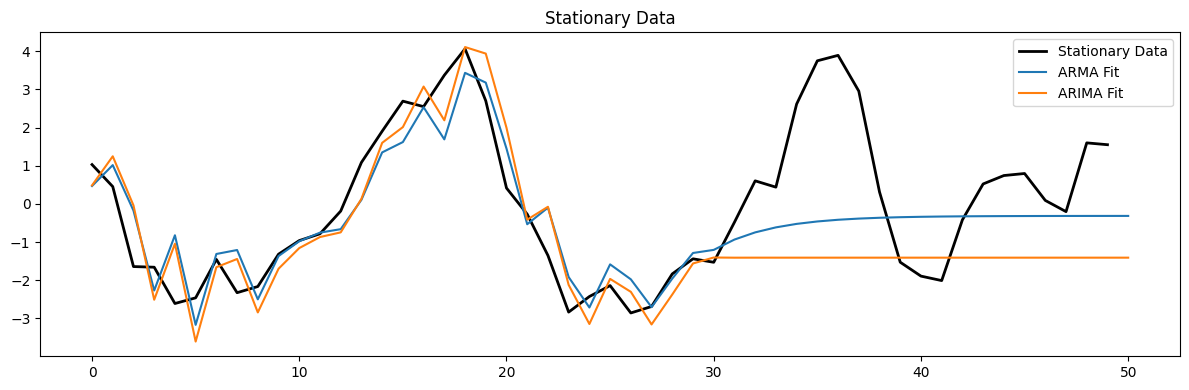

In [58]:
# Fit models to stationary data
arma_model = ARIMA(arma_data[:-20], order=(1, 0, 1)).fit()
arima_model = ARIMA(arma_data[:-20], order=(1, 1, 1)).fit()

plt.figure(figsize=(12, 4))
plt.plot(arma_data[-50:], 'k', label='Stationary Data', linewidth=2)
plt.plot(arma_model.predict(200,250), label='ARMA Fit')
plt.plot(arima_model.predict(200, 250), label='ARIMA Fit')
plt.legend()
plt.title('Stationary Data')
plt.tight_layout();

print(len(arma_model.predict(10)))

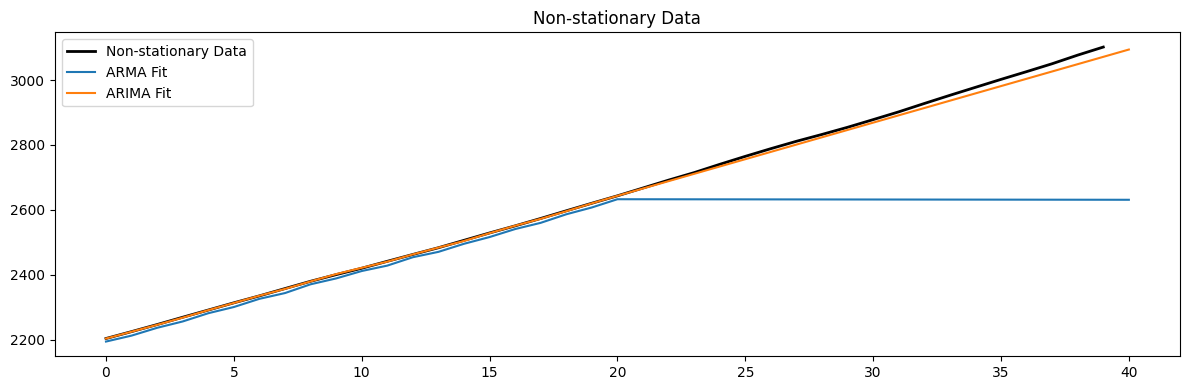

In [59]:
# Fit models to non-stationary data
arma_model = ARIMA(non_stationary_data[:-20], order=(1, 0, 1)).fit()
arima_model = ARIMA(non_stationary_data[:-20], order=(1, 2, 1)).fit()

plt.figure(figsize=(12, 4))
plt.plot(non_stationary_data[-40:], 'k', label='Non-stationary Data', linewidth=2)
plt.plot(arma_model.predict(210,250), label='ARMA Fit')
plt.plot(arima_model.predict(210,250), label='ARIMA Fit')
plt.legend()
plt.title('Non-stationary Data')
plt.tight_layout();

---

## SARIMA

- Чтобы применить ARMA и ARIMA, нам нужно удалить сезонную составляющую.
- После вычисления прогнозов нам пришлось вернуть сезонную составляющую.
- Было бы удобно напрямую работать с данными с сезонностью.

- SARIMA — это расширение ARIMA, включающее сезонные условия.
- Модель определяется как SARIMA $(p, d, q) \times (P, D, Q, s)$:
  - Регулярные компоненты ARIMA $(p, d, q)$.
  - Сезонные компоненты $(P, D, Q, s)$, где:
    - $P$: Сезонный авторегрессионный порядок.
    - $D$: Сезонный дифференцирующий порядок.
    - $Q$: Сезонный скользящий средний порядок.
    - $s$: Количество временных шагов для одного сезонного периода.

**Как выбрать значения $s, P, D, Q$?**
- $s$:
    - Является ли основная сезонность в данных.
    - Мы уже знаем, как ее найти.
- $P$ и $Q$:
    - На графиках PACF/ACF должен присутствовать пик на $s$-м лаге (и потенциально кратные $s$).
    - Например, если $s = 12$, пики могут быть и на $(s*n)^{th}$ лагах.
    - Выберите лаги с наибольшими пиками в качестве кандидатов на $P$ или $Q$.
- $D$:
    - Является ли число сезонных дифференциаций, необходимых для того, чтобы сделать временной ряд стационарным.
    - Часто определяется методом проб и ошибок или путем изучения данных с сезонными дифференциациями.

**💡 Практическое правило**
- Перед выбором $P$ и $Q$ убедитесь, что ряд сезонно стационарен, применив сезонную дифференциацию, если необходимо ($D$).
- Посмотрите на график ACF, чтобы определить сезонный порядок скользящего среднего $Q$.
  - Найдите значимые автокорреляции при сезонных лагах (кратные $s$).
  - Если график ACF показывает резкий срез сезонных лагов, это указывает на порядок сезонного компонента MA ($Q$).

- Посмотрите на график PACF, чтобы определить сезонный авторегрессионный порядок $P$.
  - Найдите значимые пики при кратных сезонности $s$.
  - Резкий срез в PACF при сезонном лаге указывает на необходимый порядок сезонных членов AR ($P$).

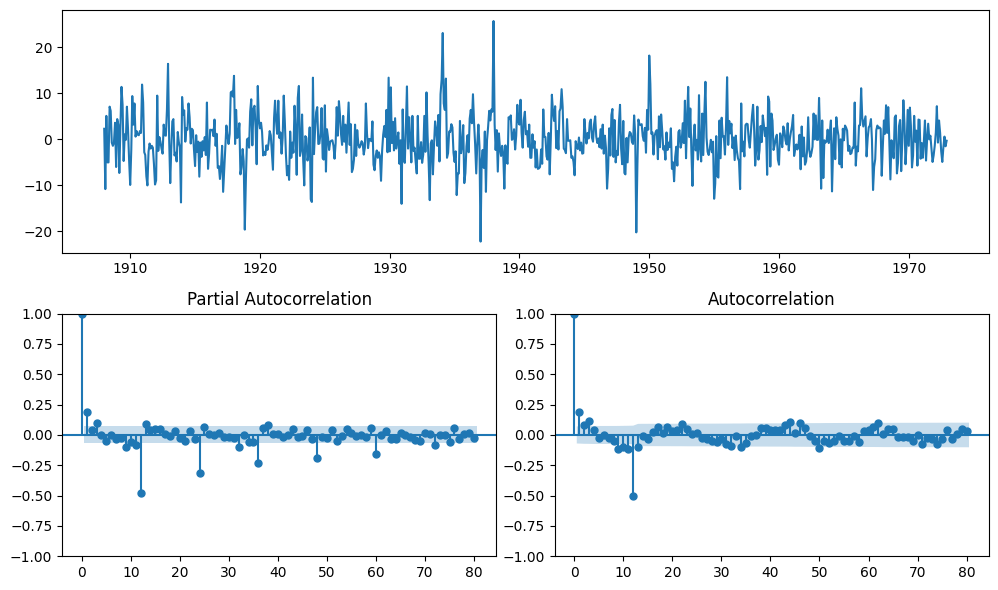

In [60]:
diff_ts = monthly_temp['temp'].diff(periods=12).dropna()

fig = plt.figure(figsize=(10, 6))
ax1 = plt.subplot2grid((2, 2), (0, 0), colspan=2)
ax1.plot(diff_ts)
ax2 = plt.subplot2grid((2, 2), (1, 0))
plot_pacf(diff_ts, lags=80, ax=ax2)
ax3 = plt.subplot2grid((2, 2), (1, 1))
plot_acf(diff_ts, lags=80, ax=ax3)
plt.tight_layout();

In [62]:
# fit SARIMA monthly based on helper plots
sar = ss.tsa.statespace.sarimax.SARIMAX(monthly_temp[:750].temp,
                                order=(2,1,2),
                                seasonal_order=(0,1,1,12),
                                trend='c').fit(disp=False)
sar.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                       
============================================================================================
Dep. Variable:                                 temp   No. Observations:                  750
Model:             SARIMAX(2, 1, 2)x(0, 1, [1], 12)   Log Likelihood               -2026.067
Date:                              Thu, 12 Feb 2026   AIC                           4066.135
Time:                                      18:26:44   BIC                           4098.353
Sample:                                  01-01-1907   HQIC                          4078.559
                                       - 06-01-1969                                         
Covariance Type:                                opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept  -6.668e-05      0.000     -0.373      0.709      -0.000       0.000
ar.L1         -0.7652      0.168     -4.554      0.000      -1.095      -0.436
ar.L2          0.1791      0.042      4.285      0.000       0.097       0.261
ma.L1         -0.0550      0.179     -0.307      0.759      -0.406       0.296
ma.L2         -0.9426      0.171     -5.526      0.000      -1.277      -0.608
ma.S.L12      -0.9813      0.039    -25.161      0.000      -1.058      -0.905
sigma2        13.3650      0.934     14.315      0.000      11.535      15.195
===================================================================================
Ljung-Box (L1) (Q):                   0.03   Jarque-Bera (JB):               201.85
Prob(Q):                              0.86   Prob(JB):                         0.00
Heteroskedasticity (H):               0.77   Skew:                            -0.55
Prob(H) (two-sided):                  0.04   Kurtosis:                         5.32
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

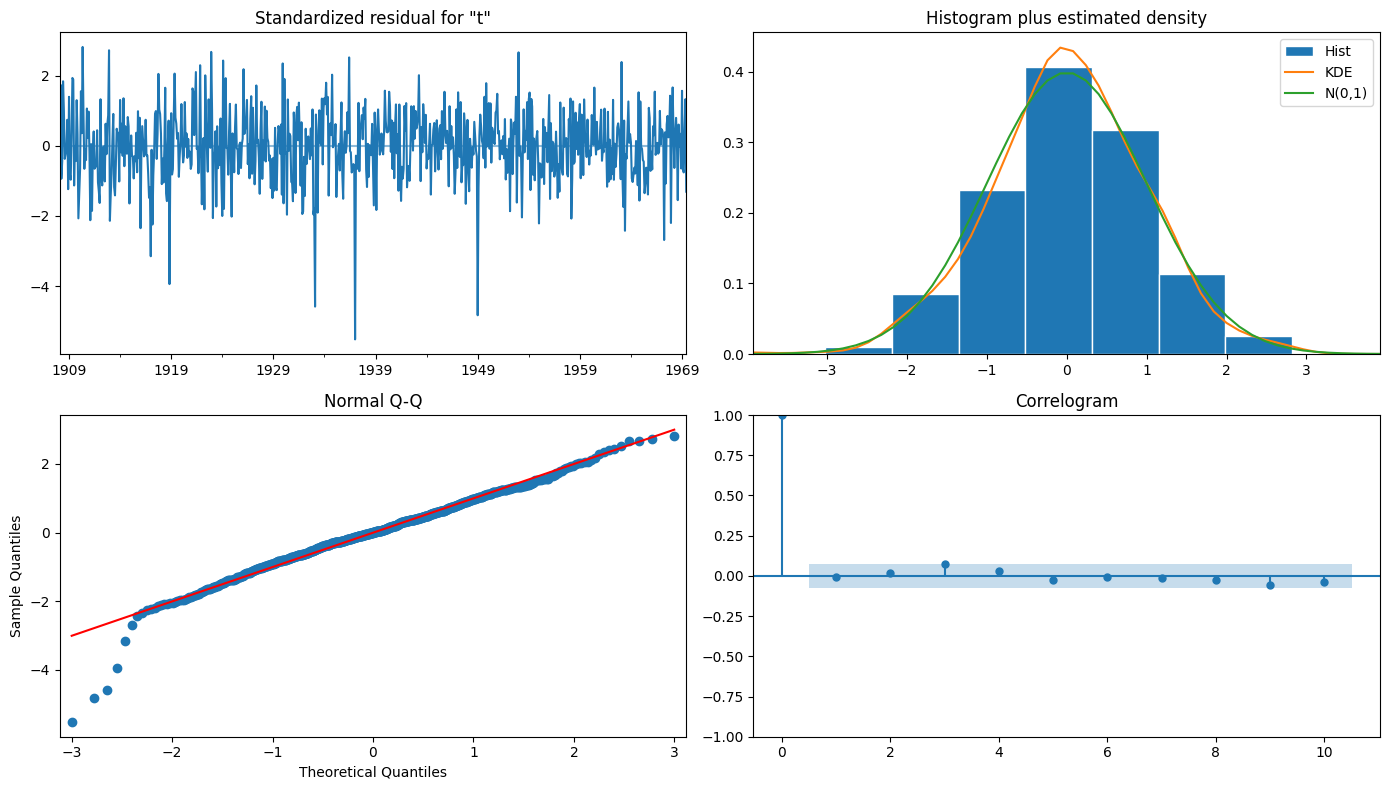

In [63]:
sar.plot_diagnostics(figsize=(14, 8))
plt.tight_layout();

MSE: 9.21


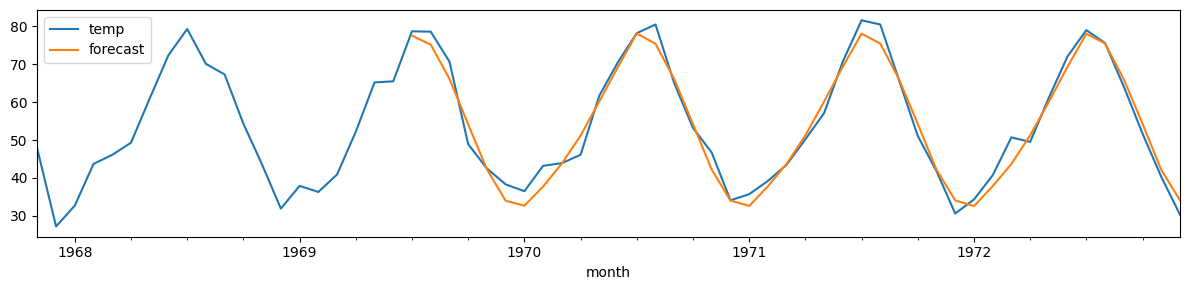

In [64]:
monthly_temp['forecast'] = sar.predict(start = 750, end= 792, dynamic=False)
monthly_temp[730:][['temp', 'forecast']].plot(figsize=(12, 3))
plt.tight_layout();
print(f"MSE: {mse(monthly_temp['temp'][-42:],monthly_temp['forecast'][-42:]):.2f}")

## AutoARIMA

- На этом этапе должно быть ясно, что определение оптимальной модели SARIMA затруднительно.
- Это требует тщательного анализа, проб и ошибок и некоторого опыта.
- В следующей шпаргалке обобщены некоторые практические правила выбора модели.

**💡 Шпаргалка: настройка коэффициентов**

<center>

|Форма ACF|Рекомендованная модель|
|---|:---|
|Экспоненциальная, спадающая до нуля|AR-модель. Используйте PACF для определения порядка AR-модели.|
|Чередование положительных и отрицательных, спадающая до нуля|AR-модель. Используйте PACF для определения порядка.|
|Один или несколько пиков, остальные по сути нулевые|MA-модель, порядок определяется тем, где график становится нулевым.|
|Спад, начинающийся после нескольких задержек|Смешанная AR- и MA-модель (ARMA).|
|Все нулевые или близкие к нулю|Данные по сути случайны.|
|Высокие значения с фиксированными интервалами|SARIMA.|
|Нет спада до нуля|Ряд не является стационарным.|

</center>

- Альтернативой ручному выбору модели является использование автоматизированных процедур.
- Здесь вступает AutoARIMA.
- AutoARIMA требует указать максимальный диапазон значений для проверки.
- После этого он пытается найти лучшую конфигурацию среди возможных.
- Полный список и описание доступных опций см. [здесь](https://alkaline-ml.com/pmdarima/modules/generated/pmdarima.arima.auto_arima.html).

In [65]:
# Split the data into train and test sets
train, test = monthly_temp[:750].temp, monthly_temp[750:].temp

# Use auto_arima to find the best ARIMA model
model = pm.auto_arima(train,
                      start_p=0, start_q=0,
                      test='adf',       # Use adftest to find optimal 'd'
                      max_p=2, max_q=2, # Maximum p and q
                      m=12,             # Seasonality
                      start_P=0, start_Q=0,
                      max_P=2, max_Q=2, # Maximum p and q
                      seasonal=True,    # Seasonal ARIMA
                      d=None,           # Let model determine 'd'
                      D=1,              # Seasonal difference
                      trace=True,       # Print status on the fits
                      error_action='ignore',
                      suppress_warnings=True,
                      stepwise=True)    # Stepwise search to find the best model

Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,1,0)[12] intercept   : AIC=4558.569, Time=0.04 sec
 ARIMA(1,0,0)(1,1,0)[12] intercept   : AIC=4318.918, Time=0.24 sec
 ARIMA(0,0,1)(0,1,1)[12] intercept   : AIC=inf, Time=0.76 sec
 ARIMA(0,0,0)(0,1,0)[12]             : AIC=4556.588, Time=0.03 sec
 ARIMA(1,0,0)(0,1,0)[12] intercept   : AIC=4531.290, Time=0.06 sec
 ARIMA(1,0,0)(2,1,0)[12] intercept   : AIC=4230.055, Time=0.64 sec
 ARIMA(1,0,0)(2,1,1)[12] intercept   : AIC=inf, Time=1.31 sec
 ARIMA(1,0,0)(1,1,1)[12] intercept   : AIC=inf, Time=0.58 sec
 ARIMA(0,0,0)(2,1,0)[12] intercept   : AIC=4256.241, Time=0.46 sec
 ARIMA(2,0,0)(2,1,0)[12] intercept   : AIC=4230.500, Time=0.78 sec
 ARIMA(1,0,1)(2,1,0)[12] intercept   : AIC=4228.386, Time=0.90 sec
 ARIMA(1,0,1)(1,1,0)[12] intercept   : AIC=4317.592, Time=0.36 sec
 ARIMA(1,0,1)(2,1,1)[12] intercept   : AIC=inf, Time=1.87 sec
 ARIMA(1,0,1)(1,1,1)[12] intercept   : AIC=inf, Time=0.90 sec
 ARIMA(0,0,1)(2,1,0)[12] intercept   : AIC=4

                                      SARIMAX Results                                      
Dep. Variable:                                   y   No. Observations:                  750
Model:             SARIMAX(1, 0, 1)x(2, 1, [], 12)   Log Likelihood               -2108.234
Date:                             Thu, 12 Feb 2026   AIC                           4226.467
Time:                                     18:33:31   BIC                           4249.487
Sample:                                 01-01-1907   HQIC                          4235.344
                                      - 06-01-1969                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.5814      0.144      4.027      0.000       0.298       0.864
ma.L1         -0.4101      

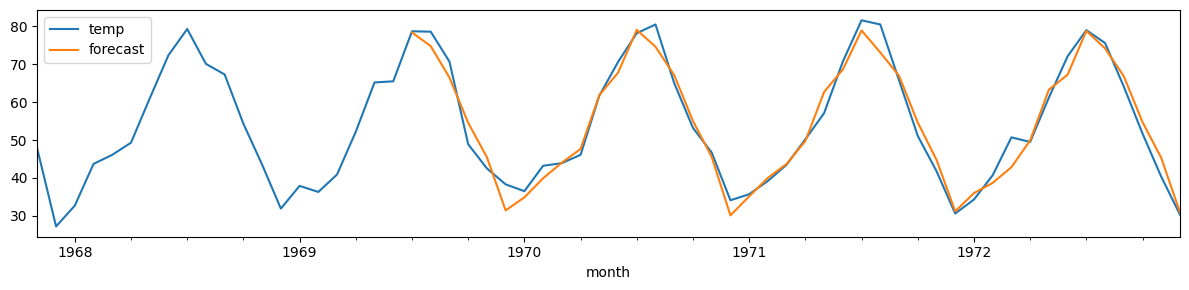

In [67]:
# Summarize the model
print(model.summary())

# Forecast future values
monthly_temp['forecast'] = model.predict(n_periods=len(test))
monthly_temp[730:][['temp', 'forecast']].plot(figsize=(12, 3))
plt.tight_layout();
print(f"MSE: {mse(monthly_temp['temp'][-42:],monthly_temp['forecast'][-42:]):.2f}")

### AutoARIMA или не AutoARIMA?

Несмотря на то, что `auto_arima` очень удобна, как и все автоматизированные процедуры, она имеет свои недостатки.

1. `auto_arima` может быть *вычислительно затратным*, особенно для больших наборов данных и при исследовании широкого спектра моделей.

2. Автоматизированный выбор модели не обладает качественными знаниями, которые человек мог бы привнести в процесс моделирования.
   - К ним относятся понимание бизнес-циклов, внешних факторов или аномалий в данных.

3. Значения по умолчанию в `auto_arima` могут быть не оптимальными для всех данных временных рядов.
   - Диапазон исследуемых значений должен корректироваться каждый раз должным образом.
   - Это может оказаться почти таким же сложным, как и выбор модели вручную.

4. `auto_arima` требует достаточно длинных временных рядов для точного определения закономерностей и сезонности.

5. Выбор лучшей модели обычно основывается на *статистических критериях*, таких как AIC или BIC.
   - Они не всегда могут соответствовать практическим показателям производительности, таким как MSE.

## Grid search

- Выбор лучшей модели ARIMA — это одновременно и искусство, и наука, включающая итерации и уточнения.
- Распространенный подход заключается в выборе набора кандидатов для $(p,d,q)\times (P,D,Q,s)$ и подборе модели для каждой возможной комбинации.

- Для каждой подходящей модели:
    - Проанализируйте остатки, используя визуальные методы и статистические тесты, обсуждавшиеся ранее.
    - Оцените эффективность прогнозирования. 🤔 Как?
    - Оцените ее сложность. 🤔 Как?

### Эффективность прогнозирования

Используйте MSE и/или MAPE для оценки эффективности прогнозирования модели.

**Среднеквадратическая ошибка (MSE)**

- MSE — это среднее квадратичных разностей между наблюдаемыми значениями и прогнозами.
- $MSE = \frac{1}{n}\sum_{i=1}^{n}(Y_i - \hat{Y}_i)^2$, где $Y_i$ — фактическое наблюдение, а $\hat{Y}_i$ — прогнозируемое значение.
- При выборе модели SARIMA предпочтение отдается модели с более низким MSE, что указывает на лучшее соответствие данным.

**Средняя абсолютная процентная ошибка (MAPE)**

- MAPE — это среднее значение абсолютных процентных ошибок прогнозов.
- $MAPE = \frac{100\%}{n}\sum_{i=1}^{n}\left|\frac{Y_i - \hat{Y}_i}{Y_i}\right|$, где $Y_i$ — фактическое наблюдение, а $\hat{Y}_i$ — прогнозируемое значение.
- MAPE выражает ошибки в процентах, что упрощает понимание величины ошибок прогнозирования.
- Если вы сравниваете модели, которые предсказывают разные величины (например, доллары и проданные единицы), процентная ошибка позволяет проводить более сопоставимое сравнение.
- Кроме того, когда вас больше интересует относительный размер ошибок, чем их абсолютный размер, MAPE актуален.
- Наконец, MAPE полезен, когда величина данных значительно различается.

### Сложность модели

Используйте AIC или BIC для оценки сложности модели.

**Информационный критерий Акаике (AIC)**

- AIC — это мера относительного качества статистических моделей для заданного набора данных.
- Он касается компромисса между качеством соответствия модели и ее сложностью.
- $AIC = 2k - 2\ln(\hat{L})$, где $k$ — количество параметров в модели, а $\hat{L}$ — максимальное значение функции правдоподобия для модели.
- Модель с наименьшим значением AIC предпочтительна, поскольку она хорошо соответствует данным, но не слишком сложна.

**Байесовский информационный критерий (BIC)**

- Подобно AIC, BIC является еще одним критерием выбора модели, но он вводит более сильный штраф для моделей с большим количеством параметров.
- $BIC = \ln(n)k - 2\ln(\hat{L})$, где $n$ - количество наблюдений, $k$ - количество параметров, а $\hat{L}$ - максимальное правдоподобие.
- Более низкое значение BIC указывает на лучшую модель, предпочитая более простые модели сложным, особенно по мере увеличения размера выборки $n$.

### Ограничение поиска с помощью разведочного анализа данных (EDA)

- Поиск по сетке может быть очень дорогим, если выполняется исчерпывающим образом, особенно на ограниченном оборудовании.
- Разведочный анализ данных может помочь значительно сократить количество кандидатов для проверки.

#### Выбор кандидатов для дифференциации

- Начнем с определения всех кандидатов для сезонной и общей дифференциации.
- В этом случае мы уже знаем, что основная сезонность $s=12$.
- Следует ли нам сначала применить общую или сезонную дифференциацию?

**💡 Подсказка**

- Если преобладают сезонные закономерности и цель состоит в том, чтобы устранить сезонность, прежде чем рассматривать какую-либо тенденцию, начните с **сезонной дифференциации**.
- Это особенно полезно, когда сезонная закономерность сильна и очевидна.
- Если преобладающей особенностью является тенденция, вы можете начать со **стандартной дифференциации**.

- В нашем случае мы сначала используем сезонную дифференциацию.

In [68]:
# create all combinations of differencing orders, applying seasonal differencing first and then general differencing
def differencing(timeseries, s, D_max=2, d_max=2):

    # Seasonal differencing from 0 to D_max
    seas_differenced = []
    for i in range(D_max+1):
        timeseries.name = f"d0_D{i}_s{s}"
        seas_differenced.append(timeseries)
        timeseries = timeseries.diff(periods=s)
    seas_df = pd.DataFrame(seas_differenced).T

    # General differencing from 0 to d_max
    general_differenced = []
    for j, ts in enumerate(seas_differenced):
        for i in range(1,d_max+1):
            ts = ts.diff()
            ts.name = f"d{i}_D{j}_s{s}"
            general_differenced.append(ts)
    gen_df = pd.DataFrame(general_differenced).T

    # concatenate seasonal and general differencing dataframes
    return pd.concat([seas_df, gen_df], axis=1)

In [69]:
# create the differenced series
diff_series = differencing(monthly_temp['temp'], s=12, D_max=2, d_max=2)
diff_series

,d0_D0_s12,d0_D1_s12,d0_D2_s12,d1_D0_s12,d2_D0_s12,d1_D1_s12,d2_D1_s12,d1_D2_s12,d2_D2_s12
month,,,,,,,,,
1907-01-01,33.3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1907-02-01,46.0,NaN,NaN,12.7,NaN,NaN,NaN,NaN,NaN
1907-03-01,43.0,NaN,NaN,-3.0,-15.7,NaN,NaN,NaN,NaN
1907-04-01,55.0,NaN,NaN,12.0,15.0,NaN,NaN,NaN,NaN
1907-05-01,51.8,NaN,NaN,-3.2,-15.2,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...
1972-08-01,75.6,-4.9,-4.9,-3.4,-10.3,-2.3,1.7,1.1,8.4
1972-09-01,64.1,-1.7,-2.5,-11.5,-8.1,3.2,5.5,2.4,1.3
1972-10-01,51.7,0.6,2.7,-12.4,-0.9,2.3,-0.9,5.2,2.8


#### Отфильтровать нестационарных кандидатов

- Среди всех разностных временных рядов оставить только те, которые стационарны (согласно ADF).

In [70]:
# create a summary of test results of all the series
def adf_summary(diff_series):
    summary = []

    for i in diff_series:
        # unpack the results
        a, b, c, d, e, f = adfuller(diff_series[i].dropna())
        g, h, i = e.values()
        results = [a, b, c, d, g, h, i]
        summary.append(results)

    columns = ["Test Statistic", "p-value", "#Lags Used", "No. of Obs. Used",
               "Critical Value (1%)", "Critical Value (5%)", "Critical Value (10%)"]
    index = diff_series.columns
    summary = pd.DataFrame(summary, index=index, columns=columns)

    return summary

In [71]:
# create the summary
summary = adf_summary(diff_series)

# filter away results that are not stationary
summary_passed = summary[summary["p-value"] < 0.05]
summary_passed

,Test Statistic,p-value,#Lags Used,No. of Obs. Used,Critical Value (1%),Critical Value (5%),Critical Value (10%)
d0_D0_s12,-6.481466,1.291867e-08,21,770,-3.438871,-2.865301,-2.568773
d0_D1_s12,-12.658082,1.323220e-23,12,767,-3.438905,-2.865316,-2.568781
d0_D2_s12,-10.416254,1.751310e-18,14,753,-3.439064,-2.865386,-2.568818
d1_D0_s12,-12.302613,7.391771e-23,21,769,-3.438882,-2.865306,-2.568775
d2_D0_s12,-15.935084,7.651998e-29,17,772,-3.438849,-2.865291,-2.568767
d1_D1_s12,-11.846173,7.390517e-22,20,758,-3.439006,-2.865361,-2.568804
d2_D1_s12,-18.352698,2.234953e-30,21,756,-3.439029,-2.865371,-2.568810
d1_D2_s12,-12.221559,1.104309e-22,20,746,-3.439146,-2.865422,-2.568837
d2_D2_s12,-15.080476,8.468854e-28,20,745,-3.439158,-2.865427,-2.568840


In [72]:
# output indices as a list
index_list = pd.Index.tolist(summary_passed.index)

# use the list as a condition to keep stationary time-series
passed_series = diff_series[index_list].sort_index(axis=1)

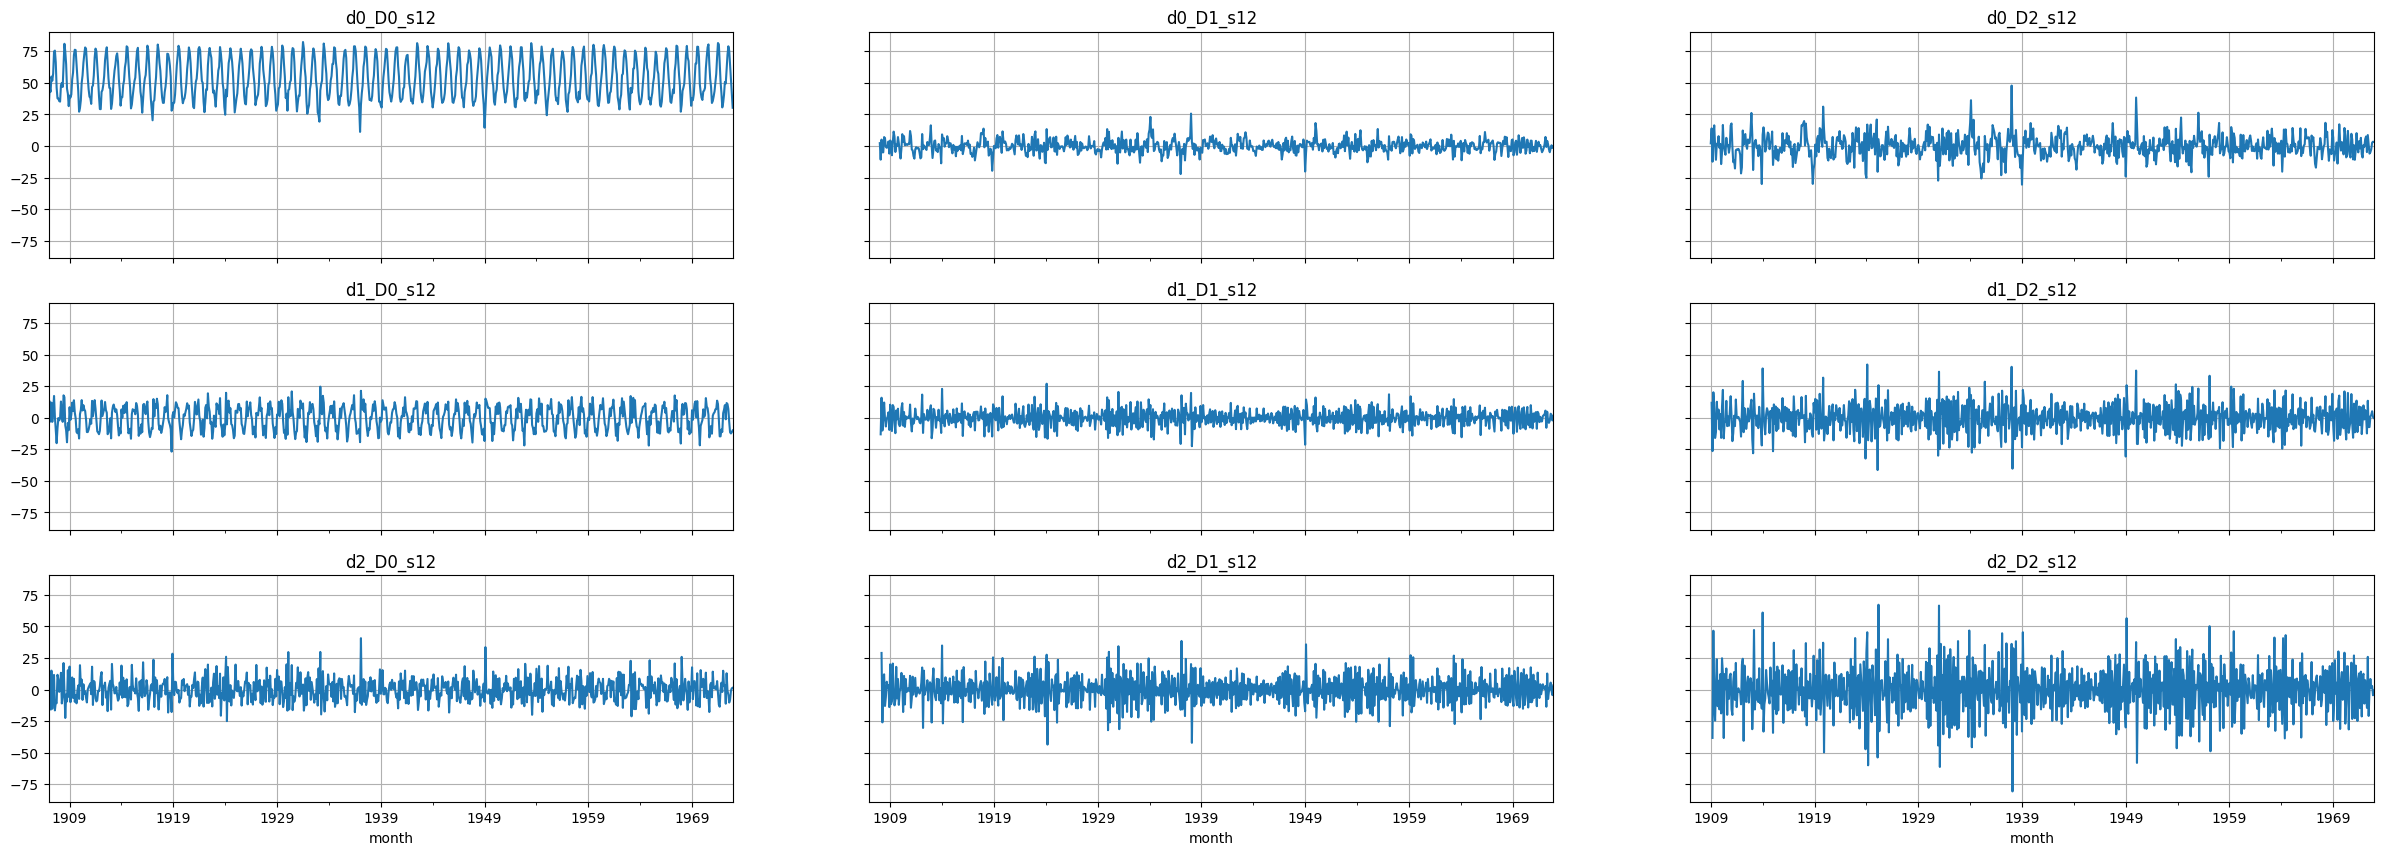

In [73]:
# Plot the final set of time series
# NOTE: these plots are too small. Make a larger plot for each series to see things better!
fig, axes = plt.subplots(3, 3, figsize=(30, 10), sharex=True, sharey=True)
for i, ax in enumerate(axes.flatten()):
    passed_series.iloc[:,i].plot(ax=ax)
    ax.set_title(passed_series.columns[i])
    ax.grid()

#### Выбор кандидатов для $p, q, P, Q$

- Мы собираемся создать скрипт для извлечения кандидатов для заказов компонента AR и MA, как в общей, так и в сезонной части.
- Мы воспользуемся функциями ACF и PACF.
- До сих пор мы рассматривали `acf_plot` и `pacf_plot`.
- Теперь нам нужно использовать `acf` и `pacf`.
- Нам нужно понять, как они связаны.

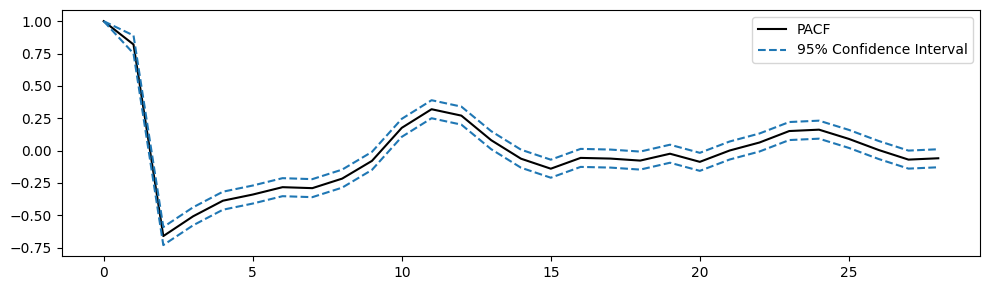

In [74]:
PACF, PACF_ci = pacf(passed_series.iloc[:,0].dropna(), alpha=0.05)

# Plot PACF
plt.figure(figsize=(10,3))
plt.plot(PACF, color='k', label='PACF')
plt.plot(PACF_ci, color='tab:blue', linestyle='--', label=['95% Confidence Interval', ''])
plt.legend()
plt.tight_layout();

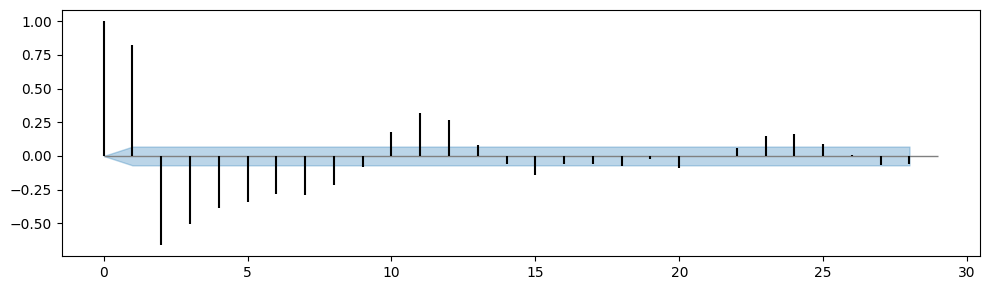

In [75]:
# subtract the confidence interval from the PACF to center the CI in zero
plt.figure(figsize=(10,3))
plt.fill_between(range(29), PACF_ci[:,0] - PACF, PACF_ci[:,1] - PACF, color='tab:blue', alpha=0.3)
plt.hlines(y=0.0, xmin=0, xmax=29, linewidth=1, color='gray')

# Display the PACF as bars
plt.vlines(range(29), [0], PACF[:29], color='black')
plt.tight_layout();

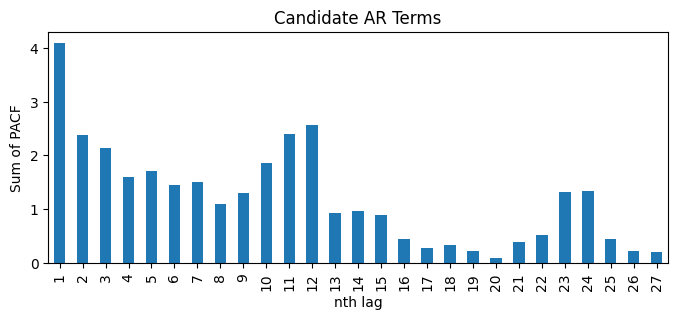

In [76]:
df_sp_p = pd.DataFrame() # create an empty dataframe to store values of significant spikes in PACF plots
for i in passed_series:
    # unpack the results into PACF and their CI
    PACF, PACF_ci = pacf(passed_series[i].dropna(), alpha=0.05, method='ywm')

    # subtract the upper and lower limits of CI by PACF to centre CI at zero
    PACF_ci_ll = PACF_ci[:,0] - PACF
    PACF_ci_ul = PACF_ci[:,1] - PACF

    # find positions of significant spikes representing possible value of p & P
    sp1 = np.where(PACF < PACF_ci_ll)[0]
    sp2 = np.where(PACF > PACF_ci_ul)[0]

    # PACF values of the significant spikes
    sp1_value = abs(PACF[PACF < PACF_ci_ll])
    sp2_value = PACF[PACF > PACF_ci_ul]

    # store values to dataframe
    sp1_series = pd.Series(sp1_value, index=sp1)
    sp2_series = pd.Series(sp2_value, index=sp2)
    df_sp_p = pd.concat((df_sp_p, sp1_series, sp2_series), axis=1)

# Sort the dataframe by index
df_sp_p = df_sp_p.sort_index()

# visualize sums of values of significant spikes in PACF plots ordered by lag
df_sp_p.iloc[1:].T.sum().plot(kind='bar', title='Candidate AR Terms', xlabel='nth lag', ylabel='Sum of PACF', figsize=(8,3));

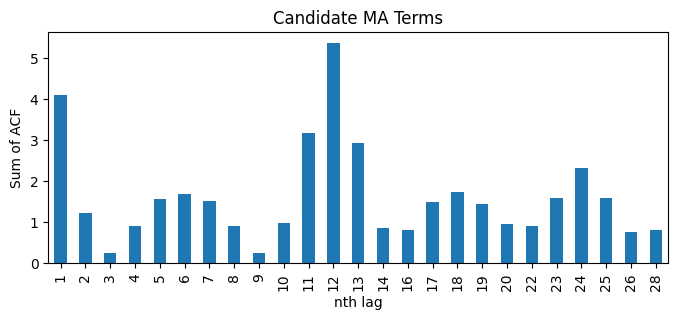

In [77]:
df_sp_q = pd.DataFrame()
for i in passed_series:
    # unpack the results into ACF and their CI
    ACF, ACF_ci = acf(passed_series[i].dropna(), alpha=0.05)

    # subtract the upper and lower limits of CI by ACF to centre CI at zero
    ACF_ci_ll = ACF_ci[:,0] - ACF
    ACF_ci_ul = ACF_ci[:,1] - ACF

    # find positions of significant spikes representing possible value of q & Q
    sp1 = np.where(ACF < ACF_ci_ll)[0]
    sp2 = np.where(ACF > ACF_ci_ul)[0]

    # ACF values of the significant spikes
    sp1_value = abs(ACF[ACF < ACF_ci_ll])
    sp2_value = ACF[ACF > ACF_ci_ul]

    # store values to dataframe
    sp1_series = pd.Series(sp1_value, index=sp1)
    sp2_series = pd.Series(sp2_value, index=sp2)
    df_sp_q = pd.concat((df_sp_q, sp1_series, sp2_series), axis=1)

# Sort the dataframe by index
df_sp_q = df_sp_q.sort_index()

# visualize sums of values of significant spikes in ACF plots ordered by lags
df_sp_q.iloc[1:].T.sum().plot(kind='bar', title='Candidate MA Terms', xlabel='nth lag', ylabel='Sum of ACF', figsize=(8,3));

#### Define the grid of values to search

In [78]:
# possible values
p = [1, 2, 3]
d = [0, 1]
q = [1, 2]
P = [0, 1]
D = [0, 1, 2]
Q = [0, 1]
s = [12]

# create all combinations of possible values
pdq = list(product(p, d, q))
PDQm = list(product(P, D, Q, s))

print(f"Number of total combinations: {len(pdq)*len(PDQm)}")

Number of total combinations: 144


#### Train the models

- We defined a function that takes every model configuration and trains a model.
- For each model, we save the MSE, MAPE, AIC and BIC.

In [79]:
warnings.simplefilter("ignore")
def SARIMA_grid(endog, order, seasonal_order):

    # create an empty list to store values
    model_info = []

    #fit the model
    for i in tqdm(order):
        for j in seasonal_order:
            try:
                model_fit = SARIMAX(endog=endog, order=i, seasonal_order=j).fit(disp=False)
                predict = model_fit.predict()

                # calculate evaluation metrics: MAPE, RMSE, AIC & BIC
                MAPE = (abs((endog-predict)[1:])/(endog[1:])).mean()
                MSE = mse(endog[1:], predict[1:])
                AIC = model_fit.aic
                BIC = model_fit.bic

                # save order, seasonal order & evaluation metrics
                model_info.append([i, j, MAPE, MSE, AIC, BIC])
            except:
                continue

    # create a dataframe to store info of all models
    columns = ["order", "seasonal_order", "MAPE", "MSE", "AIC", "BIC"]
    model_info = pd.DataFrame(data=model_info, columns=columns)
    return model_info

In [80]:
# create train-test-split
train = monthly_temp['temp'].iloc[:int(len(monthly_temp)*0.9)]
test = monthly_temp['temp'].iloc[int(len(monthly_temp)*0.9):]

In [81]:
start = time.time()

# fit all combinations into the model
model_info = SARIMA_grid(endog=train, order=pdq, seasonal_order=PDQm)

end = time.time()
print(f'time required: {end - start :.2f}')

  0%|          | 0/12 [00:00<?, ?it/s]

time required: 137.55


#### Проанализируйте результаты

- Покажите 10 лучших моделей по производительности (MSE, MAPE) и сложности модели (AIC, BIC).

In [ ]:
# 10 least MAPE models
least_MAPE = model_info.nsmallest(10, "MAPE")
least_MAPE

,order,seasonal_order,MAPE,MSE,AIC,BIC
140,"(3, 1, 2)","(1, 1, 1, 12)",0.069031,16.775574,3860.325753,3896.722959
45,"(1, 1, 2)","(1, 1, 1, 12)",0.069051,16.774401,3855.635083,3882.932987
127,"(3, 1, 1)","(1, 0, 1, 12)",0.069052,17.111851,3960.626656,3992.593363
129,"(3, 1, 1)","(1, 1, 1, 12)",0.069079,16.741013,3856.094709,3887.942264
81,"(2, 1, 1)","(1, 1, 1, 12)",0.069124,16.802831,3857.202572,3884.500476
135,"(3, 1, 2)","(0, 1, 1, 12)",0.069126,16.792647,3859.571180,3891.418735
39,"(1, 1, 2)","(0, 1, 1, 12)",0.069130,16.781150,3854.502839,3877.251093
123,"(3, 1, 1)","(0, 1, 1, 12)",0.069166,16.746288,3854.844955,3882.142859
93,"(2, 1, 2)","(1, 1, 1, 12)",0.069172,16.805178,3860.077580,3891.925136
75,"(2, 1, 1)","(0, 1, 1, 12)",0.069203,16.811213,3856.176615,3878.924868


In [ ]:
# 10 least MSE models
least_MSE = model_info.nsmallest(10, "MSE")
least_MSE

,order,seasonal_order,MAPE,MSE,AIC,BIC
129,"(3, 1, 1)","(1, 1, 1, 12)",0.069079,16.741013,3856.094709,3887.942264
123,"(3, 1, 1)","(0, 1, 1, 12)",0.069166,16.746288,3854.844955,3882.142859
45,"(1, 1, 2)","(1, 1, 1, 12)",0.069051,16.774401,3855.635083,3882.932987
140,"(3, 1, 2)","(1, 1, 1, 12)",0.069031,16.775574,3860.325753,3896.722959
39,"(1, 1, 2)","(0, 1, 1, 12)",0.069130,16.781150,3854.502839,3877.251093
135,"(3, 1, 2)","(0, 1, 1, 12)",0.069126,16.792647,3859.571180,3891.418735
81,"(2, 1, 1)","(1, 1, 1, 12)",0.069124,16.802831,3857.202572,3884.500476
93,"(2, 1, 2)","(1, 1, 1, 12)",0.069172,16.805178,3860.077580,3891.925136
75,"(2, 1, 1)","(0, 1, 1, 12)",0.069203,16.811213,3856.176615,3878.924868
87,"(2, 1, 2)","(0, 1, 1, 12)",0.069289,16.825125,3859.565036,3886.862941


In [ ]:
# 10 least AIC models
least_AIC = model_info.nsmallest(10, "AIC")
least_AIC

,order,seasonal_order,MAPE,MSE,AIC,BIC
43,"(1, 1, 2)","(1, 0, 1, 12)",132.159673,5.501298e+07,132.106052,159.506087
3,"(1, 0, 1)","(0, 1, 1, 12)",0.080283,6.149156e+01,3846.181890,3864.386212
9,"(1, 0, 1)","(1, 1, 1, 12)",0.080153,6.147133e+01,3846.879649,3869.635051
15,"(1, 0, 2)","(0, 1, 1, 12)",0.080286,6.148300e+01,3847.914835,3870.670236
51,"(2, 0, 1)","(0, 1, 1, 12)",0.080283,6.148531e+01,3847.985625,3870.741026
99,"(3, 0, 1)","(0, 1, 1, 12)",0.080295,6.144977e+01,3848.292676,3875.599158
21,"(1, 0, 2)","(1, 1, 1, 12)",0.080146,6.146176e+01,3848.568559,3875.875041
57,"(2, 0, 1)","(1, 1, 1, 12)",0.080145,6.146432e+01,3848.650344,3875.956826
105,"(3, 0, 1)","(1, 1, 1, 12)",0.080096,6.143063e+01,3849.069448,3880.927010
117,"(3, 0, 2)","(1, 1, 1, 12)",0.080081,6.140204e+01,3849.084348,3885.492991


In [ ]:
# 10 least BIC models
least_BIC = model_info.nsmallest(10, "BIC")
least_BIC

,order,seasonal_order,MAPE,MSE,AIC,BIC
43,"(1, 1, 2)","(1, 0, 1, 12)",132.159673,5.501298e+07,132.106052,159.506087
3,"(1, 0, 1)","(0, 1, 1, 12)",0.080283,6.149156e+01,3846.181890,3864.386212
9,"(1, 0, 1)","(1, 1, 1, 12)",0.080153,6.147133e+01,3846.879649,3869.635051
15,"(1, 0, 2)","(0, 1, 1, 12)",0.080286,6.148300e+01,3847.914835,3870.670236
51,"(2, 0, 1)","(0, 1, 1, 12)",0.080283,6.148531e+01,3847.985625,3870.741026
27,"(1, 1, 1)","(0, 1, 1, 12)",0.069318,1.683683e+01,3855.820879,3874.019482
99,"(3, 0, 1)","(0, 1, 1, 12)",0.080295,6.144977e+01,3848.292676,3875.599158
21,"(1, 0, 2)","(1, 1, 1, 12)",0.080146,6.146176e+01,3848.568559,3875.875041
57,"(2, 0, 1)","(1, 1, 1, 12)",0.080145,6.146432e+01,3848.650344,3875.956826
63,"(2, 0, 2)","(0, 1, 1, 12)",0.080282,6.146983e+01,3849.361800,3876.668282


- Мы можем проверить, есть ли совпадения между 4 различными группами, используя функцию `set`.

In [ ]:
set(least_MAPE.index) & set(least_MSE.index)

{39, 45, 75, 81, 93, 123, 129, 135, 140}

In [ ]:
set(least_AIC.index) & set(least_BIC.index)

{3, 9, 15, 21, 43, 51, 57, 99}

In [ ]:
set(least_MSE.index) & set(least_AIC.index)

set()

- Покажите лучшую модель по каждому показателю.

In [ ]:
# the best model by each metric
L1 = model_info[model_info.MAPE == model_info.MAPE.min()]
L2 = model_info[model_info.MSE == model_info.MSE.min()]
L3 = model_info[model_info.AIC == model_info.AIC.min()]
L4 = model_info[model_info.BIC == model_info.BIC.min()]

best_models = pd.concat((L1, L2, L3, L4))
best_models

,order,seasonal_order,MAPE,MSE,AIC,BIC
140,"(3, 1, 2)","(1, 1, 1, 12)",0.069031,1.677557e+01,3860.325753,3896.722959
129,"(3, 1, 1)","(1, 1, 1, 12)",0.069079,1.674101e+01,3856.094709,3887.942264
43,"(1, 1, 2)","(1, 0, 1, 12)",132.159673,5.501298e+07,132.106052,159.506087
43,"(1, 1, 2)","(1, 0, 1, 12)",132.159673,5.501298e+07,132.106052,159.506087


#### Вычислите производительность на тестовом наборе

- Возьмите лучшие модели, вычислите прогнозы и оцените их производительность с точки зрения MAPE по отношению к тестовым данным.

In [ ]:
# Take the configurations of the best models
ord_list = [tuple(best_models.iloc[i,0]) for i in range(best_models.shape[0])]
s_ord_list = [tuple(best_models.iloc[i,1]) for i in range(best_models.shape[0])]
preds, ci_low, ci_up, MAPE_test = [], [], [], []

# Fit the models and compute the forecasts
for i in range(4):
    model_fit = SARIMAX(endog=train, order=ord_list[i],
                        seasonal_order=s_ord_list[i]).fit(disp=False) # Fit the model
    pred_summary = model_fit.get_prediction(test.index[0],
                                            test.index[-1]).summary_frame() # Compute preds
    # Store results
    preds.append(pred_summary['mean'])
    ci_low.append(pred_summary['mean_ci_lower'][test.index])
    ci_up.append(pred_summary['mean_ci_upper'][test.index])
    MAPE_test.append((abs((test-pred_summary['mean'])/(test)).mean()))

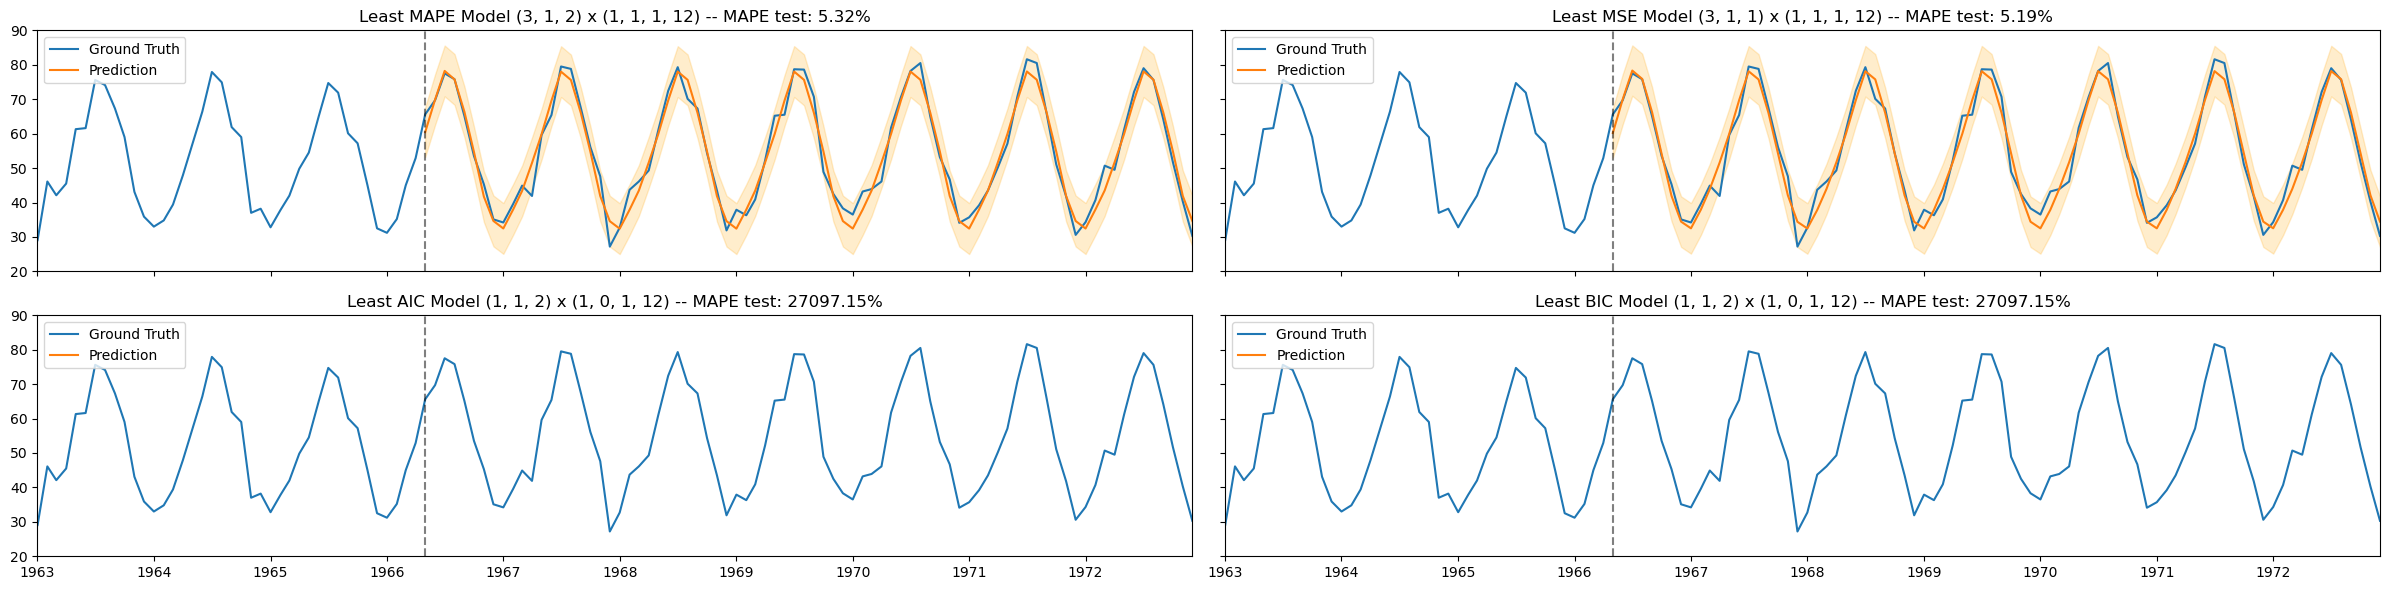

In [ ]:
# visualize the results of the fitted models
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(24,6),
                        sharex=True, sharey=True)

titles = [f'Least MAPE Model {ord_list[0]} x {s_ord_list[0]}',
          f'Least MSE Model {ord_list[1]} x {s_ord_list[1]}',
          f'Least AIC Model {ord_list[2]} x {s_ord_list[2]}',
          f'Least BIC Model {ord_list[3]} x {s_ord_list[3]}']
k = 0
for i in range(2):
    for j in range(2):
        axs[i,j].plot(monthly_temp['temp'], label='Ground Truth')
        axs[i,j].plot(preds[k], label='Prediction')
        axs[i,j].set_title(titles[k] + f' -- MAPE test: {MAPE_test[k]:.2%}')
        axs[i,j].legend()
        axs[i,j].axvline(test.index[0], color='black', alpha=0.5, linestyle='--')
        axs[i,j].fill_between(x=test.index, y1=ci_low[k], y2=ci_up[k], color='orange', alpha=0.2)
        axs[i,j].set_ylim(bottom=20, top=90)
        axs[i,j].set_xlim(left=monthly_temp.index[-120], right=monthly_temp.index[-1])
        k += 1
plt.tight_layout()
plt.show()

---

## Резюме

1. Модели авторегрессионного скользящего среднего (ARMA).
2. Модели авторегрессионного интегрированного скользящего среднего (ARIMA).
3. Модели SARIMA (модель ARIMA для данных с сезонностью).
4. Выбор лучшей модели.

---

## Упражнение

- Посмотрите на данные датчика, который отслеживает атмосферный CO2 из непрерывных проб воздуха в обсерватории Мауна-Лоа на Гавайях. Эти данные включают пробы CO2 с марта 1958 года по декабрь 1980 года.

In [82]:
co2 = pd.read_csv('https://zenodo.org/records/10951538/files/arima_co2.csv?download=1',
                  header = 0,
                  names = ['idx', 'co2'],
                  skipfooter = 2)

# convert the column idx into a datetime object and set it as the index
co2['idx'] = pd.to_datetime(co2['idx'])
co2.set_index('idx', inplace=True)

# Rmove the name "idx" from the index column
co2.index.name = None
co2

,co2
1965-01-01,319.32
1965-02-01,320.36
1965-03-01,320.82
1965-04-01,322.06
1965-05-01,322.17
...,...
1980-08-01,337.19
1980-09-01,335.49
1980-10-01,336.63
1980-11-01,337.74


- Определите наличие основного тренда и сезонности в данных.
- Определите, являются ли данные стационарными.
- Разделите данные на обучающие (90%) и тестовые (10%).
- Найдите набор моделей-кандидатов SARIMAX, посмотрев на ACF и PACF.
- Выполните поиск по сетке для моделей-кандидатов.
- Выберите лучшие модели на основе показателей производительности, сложности модели и нормальности остатков.
- Сравните лучшую найденную вами модель с моделью из autoarima.

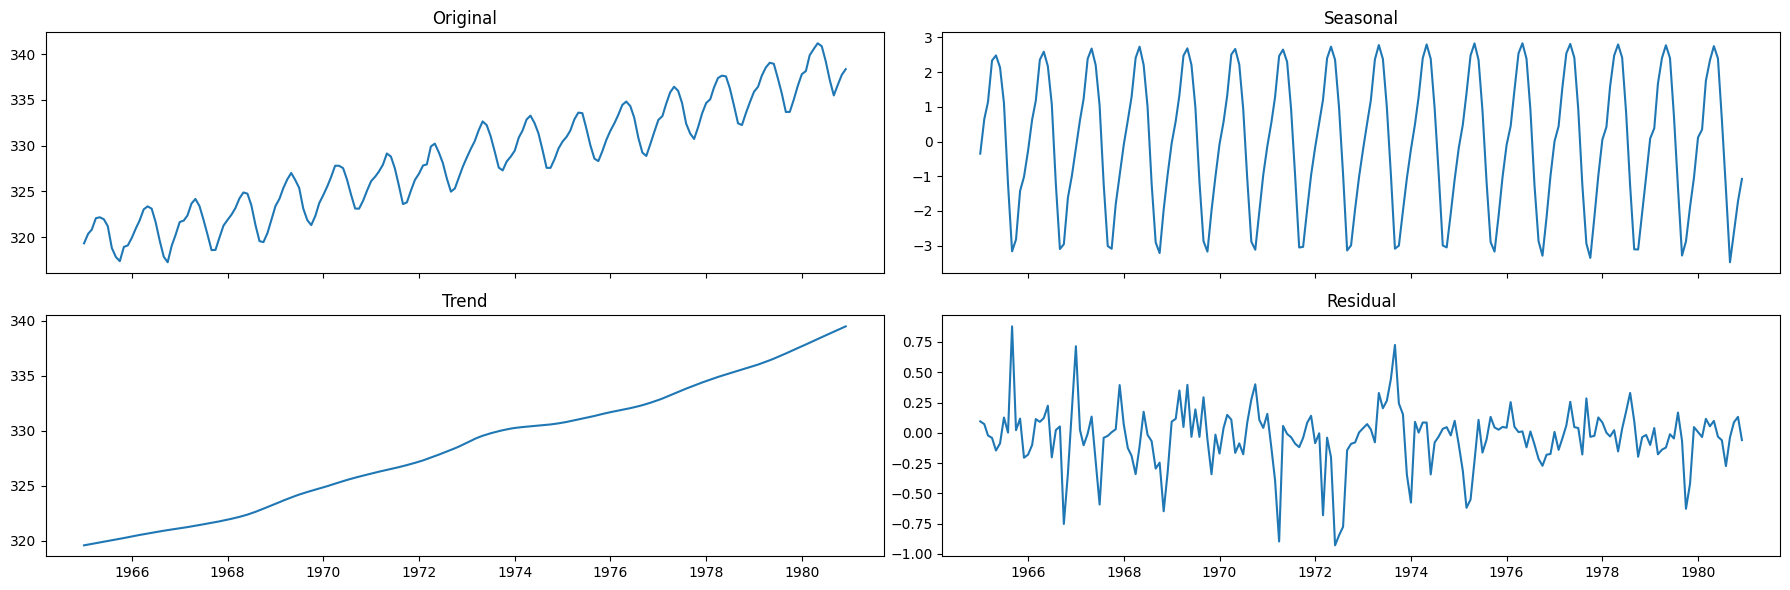

In [87]:
decomposition = STL(endog=co2['co2'], period=12, robust=True).fit()
seasonal, trend, resid = decomposition.seasonal, decomposition.trend, decomposition.resid

fig, axs = plt.subplots(2,2, sharex=True, figsize=(18,6))
axs[0,0].plot(co2['co2'])
axs[0,0].set_title('Original')
axs[0,1].plot(seasonal)
axs[0,1].set_title('Seasonal')
axs[1,0].plot(trend)
axs[1,0].set_title('Trend')
axs[1,1].plot(resid)
axs[1,1].set_title('Residual')
plt.tight_layout()

In [92]:
from statsmodels.tsa.stattools import adfuller
adf, pvalue, _, _, _, _ = adfuller(co2.co2, regression='c')
print(f"ADF: {adf:.2f}")
print(f"p-value: {pvalue:.3f}")

ADF: 1.27
p-value: 0.996


p-value > 0, следовательно мы не можем отбросить нулевую гипотезу и ряд явялется нестационарным! 

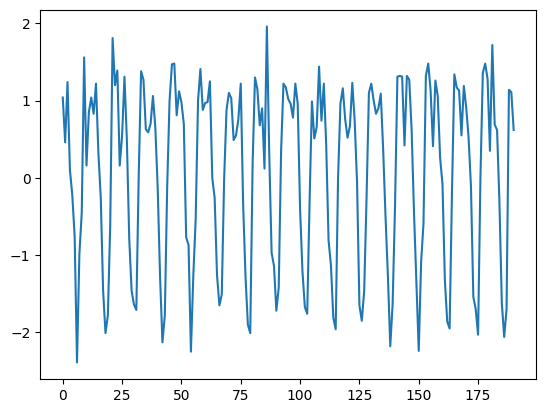

In [150]:
import numpy as np
# приблизим ряд к стационарному
data = np.array(co2['co2'])
data_diff = np.diff(data)
plt.plot(data_diff)

<Figure size 1500x500 with 0 Axes>

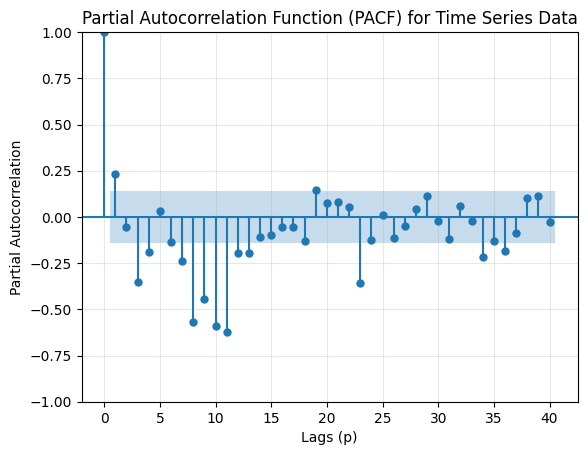

In [153]:
from statsmodels.graphics.tsaplots import plot_pacf

def plot_ar_order_determination(data, lags=40, series_name="Time Series Data"):

    if isinstance(data, np.ndarray):
        data = pd.Series(data)
        
    stationary_data = data.diff().dropna()

    plt.figure(figsize=(15, 5))
    plot_pacf(stationary_data, lags=lags, method='ols', title=f'Partial Autocorrelation Function (PACF) for {series_name}')
    
    plt.xlabel('Lags (p)')
    plt.ylabel('Partial Autocorrelation')
    plt.grid(True, alpha=0.3)
    plt.show()

plot_ar_order_determination(
    data_diff,
    lags=40
)

In [154]:
import itertools
import statsmodels.api as sm
from sklearn.metrics import mean_squared_error


def tune_sarimax(series, horizon=10, season_len=12, max_order=1):

    ts = pd.Series(series).dropna()

    train = ts.iloc[:-horizon]
    test = ts.iloc[-horizon:]

    orders = list(itertools.product(range(max_order + 1), repeat=3))
    seasonal_orders = [(P, D, Q, season_len) for P, D, Q in orders]

    best_score = np.inf
    best_params = None

    for order_cfg in orders:
        for seasonal_cfg in seasonal_orders:
            try:
                model = sm.tsa.statespace.SARIMAX(
                    train,
                    order=order_cfg,
                    seasonal_order=seasonal_cfg,
                    enforce_stationarity=False,
                    enforce_invertibility=False
                )

                result = model.fit(disp=False)
                forecast = result.forecast(horizon)

                y_true = np.asarray(test).ravel()
                y_pred = np.asarray(forecast).ravel()

                rmse = np.sqrt(mean_squared_error(y_true, y_pred))

                if rmse < best_score:
                    best_score = rmse
                    best_params = (order_cfg, seasonal_cfg)

            except Exception:
                continue

    if best_params is None:
        raise RuntimeError("SARIMAX не смог обучиться ни на одной конфигурации.")

    print(f"Best model: {best_params}")
    print(f"RMSE: {best_score:.4f}")

    return best_params


best_cfg = tune_sarimax(data, horizon=10)
best_cfg


Best model: ((1, 0, 1), (1, 0, 0, 12))
RMSE: 0.5176


((1, 0, 1), (1, 0, 0, 12))

In [155]:
from sklearn.base import BaseEstimator, RegressorMixin
from statsmodels.tsa.statespace.sarimax import SARIMAX

from sklearn.model_selection import GridSearchCV, TimeSeriesSplit
from sklearn.metrics import mean_squared_error
from pmdarima import auto_arima


class SklearnSARIMAX(BaseEstimator, RegressorMixin):
    def __init__(self, arima_order=(1, 0, 1), seasonal_cfg=(0, 0, 0, 0)):
        self.arima_order = arima_order
        self.seasonal_cfg = seasonal_cfg

    def fit(self, X, y=None):
        self._model = SARIMAX(
            X,
            order=self.arima_order,
            seasonal_order=self.seasonal_cfg,
            enforce_stationarity=False,
            enforce_invertibility=False
        )
        self._fit_res = self._model.fit(disp=False)
        return self

    def predict(self, X):
        horizon = len(X)
        return self._fit_res.forecast(steps=horizon)



In [156]:
def benchmark_sarimax_strategies(
    series,
    forecast_horizon=10,
    seasonal_period=12
):
    ts = pd.Series(series).dropna()

    train_ts = ts.iloc[:-forecast_horizon]
    test_ts = ts.iloc[-forecast_horizon:]

    search_space = {
        "arima_order": [(1,1,1), (2,1,0), (0,1,1)],
        "seasonal_cfg": [
            (1,1,1,seasonal_period),
            (0,1,1,seasonal_period),
            (0,0,0,0)
        ]
    }

    splitter = TimeSeriesSplit(n_splits=2)

    print(">> Fitting SARIMAX via sklearn GridSearch")
    grid = GridSearchCV(
        estimator=SklearnSARIMAX(),
        param_grid=search_space,
        cv=splitter,
        scoring="neg_root_mean_squared_error"
    )
    grid.fit(train_ts)

    best_grid_model = grid.best_estimator_
    grid_forecast = best_grid_model.predict(test_ts)

    print(">> Fitting AutoARIMA baseline")
    auto_model = auto_arima(
        train_ts,
        seasonal=True,
        m=seasonal_period,
        suppress_warnings=True
    )
    auto_forecast = auto_model.predict(n_periods=forecast_horizon)

    y_true = np.asarray(test_ts)
    grid_pred = np.asarray(grid_forecast)
    auto_pred = np.asarray(auto_forecast)

    rmse_grid = np.sqrt(mean_squared_error(y_true, grid_pred))
    rmse_auto = np.sqrt(mean_squared_error(y_true, auto_pred))

    plt.figure(figsize=(12, 6))
    idx = np.arange(len(y_true))

    plt.plot(idx, y_true, label="Observed", color="black", lw=2)
    plt.plot(idx, grid_pred, "--o", label="GridSearch SARIMAX", color = 'blue')
    plt.plot(idx, auto_pred, ":x", label="AutoARIMA",color='red')

    plt.title(
        f"Grid SARIMAX: {best_grid_model.arima_order} x {best_grid_model.seasonal_cfg}"
        f" (RMSE={rmse_grid:.4f})\n"
        f"AutoARIMA: {auto_model.order} x {auto_model.seasonal_order}"
        f" (RMSE={rmse_auto:.4f})"
    )

    plt.xlabel("Forecast step")
    plt.ylabel("Series value")
    plt.legend()
    plt.grid(alpha=0.3)
    plt.show()

    return best_grid_model, auto_model


>> Fitting SARIMAX via sklearn GridSearch
>> Fitting AutoARIMA baseline


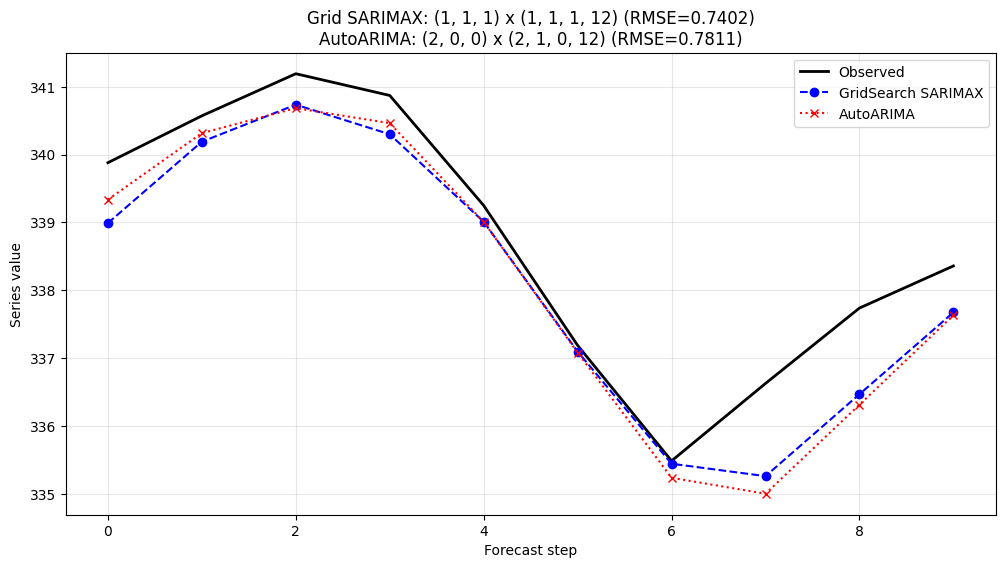

In [157]:
best_manual, best_auto = benchmark_sarimax_strategies(
    data,
    forecast_horizon=10
)
